### Import dataset and make it ready for processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
import sys

In [3]:
PATH = "./dataset/manual_feedback_preprocessed.csv"

if not os.path.exists(PATH):
    print(f"File not found at {PATH}. Please check the path and try again.")
else:
    try:
        main_df = pd.read_csv(PATH)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")


Data loaded successfully.


In [40]:
main_df["KC Label"]

0      Looping Constructs, Using Clear Method Names, ...
1      Using Docstrings and Comments, Testing Code an...
2       Recursion Concepts, Recursive Formula, Using ...
3      Recursion Concepts, Testing Code and Validatin...
4      Recursion Concepts, Recursive Formula, Testing...
                             ...                        
366    String Indexing and Slicing, String Methods, L...
367    Defining a Class, Initializing and Storing Obj...
368    Using the time Module, Defining a Class, Insta...
369    Using the time Module, Defining a Class, Insta...
370    Defining a Class, Initializing and Storing Obj...
Name: KC Label, Length: 371, dtype: object

In [ ]:
main_df["KC Label"] = main_df["KC Label"].str.replace("Loping Constructs", "Looping Constructs", regex=False)

In [54]:
# Split the "Error Label" column by comma, strip whitespace and count unique values
kc_labels = main_df["KC Label"].str.split(",").explode().str.strip()
kc_labels = kc_labels.value_counts()
# Convert from series to dataframe
kc_labels = kc_labels.reset_index()
kc_labels.columns = ["KC Label", "Count"]

# Find similar KC's that have almost similar text

kc_labels


,KC Label,Count
0,Edge Case Handling,130
1,Using Clear Method and Variable Names,105
2,Looping Constructs,102
3,Base Case Handling,98
4,Using self to Access Attributes,89
5,Conditional Logic,89
6,Using Docstrings and Comments,86
7,String Methods,83
8,Recursion Concepts,79
9,Testing Code and Validating Output,77


In [5]:
error_labels = main_df["Error Label"].str.split(",").explode().str.strip()
error_labels.value_counts()

Error Label
Logical              237
Understandability    233
Syntax               221
Efficiency           125
Name: count, dtype: int64

## Plotting Syntax and KC stats grouped by (Students/Exercises)

In [31]:
# =========================
# Generic KC + Error Pipeline
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.cm import get_cmap
from pathlib import Path
SURVEY_EX = [586, 683, 760, 434, 568, 547, 2171, 1949, 2135]
EX_TO_E   = {ex: f"E{i+1}" for i, ex in enumerate(SURVEY_EX)}
# -------------------------
# Utilities
# -------------------------
def _lighten(color, amount=0.45):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount * r, (1 - amount) + amount * g, (1 - amount) + amount * b

def _percent_labels(ax, x, base, val):
    ax.text(
        x, base + val/2.0, f"{val:.0%}",
        ha="center", va="center", fontsize=11, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=1.4, foreground="white")]
    )

# -------------------------
# KC processing (generic)
# -------------------------
def process_kc_data(main_df: pd.DataFrame, group_col: str = "Student", kc_prefix: str = "KC"):
    """
    Returns:
      pivot_df: index = group values, columns = ['Top1','Top2','Top3','Others'] as proportions
      labels_map: {group_value: (top1_label, top2_label, top3_label)}
    """
    # locate KC columns once
    kc_cols = [c for c in main_df.columns if c.startswith(kc_prefix)]
    if not kc_cols:
        raise ValueError(f"No columns starting with '{kc_prefix}'.")

    # melt -> explode per individual KC token
    df = main_df[kc_cols + [group_col]].copy()
    melted = df.melt(id_vars=[group_col], var_name="KC_Column", value_name="KC_Value").dropna(subset=["KC_Value"])
    exploded = melted.copy()
    exploded["KC_Value"] = exploded["KC_Value"].astype(str).str.split(",")
    exploded = exploded.explode("KC_Value")
    exploded["KC_Value"] = exploded["KC_Value"].astype(str).str.strip()
    exploded = exploded[(exploded["KC_Value"] != "") & (exploded["KC_Value"] != "nan")]

    # counts per group x KC
    counts = (
        exploded.groupby([group_col, "KC_Value"])
        .size()
        .reset_index(name="Count")
    )

    # share per group
    totals = counts.groupby(group_col)["Count"].transform("sum")
    counts["Percentage"] = counts["Count"] / totals

    # build top1/2/3 + others and label map
    seg = {}
    labels_map = {}
    for gval, sub in counts.groupby(group_col):
        top3 = sub.nlargest(3, "Percentage")
        tops = top3["Percentage"].tolist()
        tops += [0.0] * (3 - len(tops))
        top1, top2, top3v = tops[:3]
        others = max(0.0, 1.0 - (top1 + top2 + top3v))
        seg[gval] = {"Top1": top1, "Top2": top2, "Top3": top3v, "Others": others}

        labels = top3["KC_Value"].tolist()
        labels += [None] * (3 - len(labels))
        labels_map[gval] = tuple(labels[:3])

    pivot_df = pd.DataFrame.from_dict(seg, orient="index").rename_axis(group_col).sort_index()
    return pivot_df, labels_map

def export_kc_csv(labels_map: dict, out_path: str):
    rows = []
    for key, (t1, t2, t3) in labels_map.items():
        rows.append({ "Group": key, "Top1 KC": t1 or "", "Top2 KC": t2 or "", "Top3 KC": t3 or "" })
    df = pd.DataFrame(rows).sort_values("Group")
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False)
    return df

# -------------------------
# KC figure (generic)
# -------------------------
def plot_top_kc_bars(pivot_df: pd.DataFrame, group_label: str, legend_pivot: tuple = (0.5, -0.12)):
    seg_order = ["Top1", "Top2", "Top3", "Others"]
    cmap = get_cmap("tab20")
    base = {"Top1": cmap(0), "Top2": cmap(2), "Top3": cmap(4), "Others": cmap(6)}
    colors = {k: _lighten(v, amount=0.45) for k, v in base.items()}
    hatches = {"Top1": "////", "Top2": "xxxx", "Top3": "....", "Others": "\\\\\\"}

    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(pivot_df.index))
    cum = np.zeros(len(pivot_df), dtype=float)

    for seg in seg_order:
        vals = pivot_df[seg].values
        ax.bar(
            x, vals, bottom=cum, color=colors[seg], hatch=hatches[seg],
            edgecolor="black", linewidth=0.8, label=seg
        )
        cum += vals

    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df.index, rotation=45, ha="right", fontsize=12)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=5))
    ax.grid(axis="y", linestyle=(0, (3, 2)), linewidth=0.8, alpha=0.6)
    ax.set_title(f"Top1 / Top2 / Top3 KC and Others by {group_label}", fontsize=15, pad=10)
    ax.set_xlabel(group_label, fontsize=14)
    ax.set_ylabel("Share of KC usage (100%)", fontsize=14)

    thr = 0.08
    for i, key in enumerate(pivot_df.index):
        base_h = 0.0
        for seg in seg_order:
            v = float(pivot_df.loc[key, seg])
            if v >= thr:
                _percent_labels(ax, i, base_h, v)
            base_h += v

    handles, labels = ax.get_legend_handles_labels()
    label_map = {"Top1": "Top1 (highest KC share)", "Top2": "Top2", "Top3": "Top3", "Others": "Others (all remaining)"}
    labels = [label_map[l] for l in labels]
    ax.legend(handles, labels, ncol=4, loc="upper center", bbox_to_anchor=legend_pivot,
              frameon=False, fontsize=13, handlelength=1.6, columnspacing=1.6)

    fig.tight_layout()
    return fig, ax

# -------------------------
# Error processing (generic)
# -------------------------
def process_error_data(df: pd.DataFrame, group_col: str = "Student"):
    """
    Returns pivot with index = group_col values, columns fixed to:
    ['Syntax','Logical','Efficiency','Understandability'] as proportions.
    """
    tmp = df.copy()
    tmp["Error Label"] = (
        tmp["Error Label"]
        .astype(str)
        .str.replace("Readability", "Understandability", regex=False)
        .str.split(",")
    )
    exploded = tmp.explode("Error Label")
    exploded["Error Label"] = exploded["Error Label"].astype(str).str.strip()
    exploded = exploded[(exploded["Error Label"] != "") & (exploded["Error Label"] != "nan")]

    counts = (
        exploded.groupby([group_col, "Error Label"])
        .size()
        .reset_index(name="Count")
    )
    totals = counts.groupby(group_col)["Count"].transform("sum")
    counts["Proportion"] = counts["Count"] / totals

    label_order = ["Syntax", "Logical", "Efficiency", "Understandability"]
    pivot = (
        counts.pivot(index=group_col, columns="Error Label", values="Proportion")
        .reindex(columns=label_order, fill_value=0.0)
        .sort_index()
    )
    return pivot

# -------------------------
# Error figure (generic)
# -------------------------
def plot_error_stacked_printsafe(pivot_df: pd.DataFrame, group_label: str, legend_pivot: tuple = (0.5, -0.12)):
    base = {"Syntax": "#1f77b4", "Logical": "#ff7f0e", "Efficiency": "#2ca02c", "Understandability": "#d62728"}
    colors = {k: _lighten(v, amount=0.45) for k, v in base.items()}
    hatches = {"Syntax": "////", "Logical": "xxxx", "Efficiency": "....", "Understandability": "\\\\\\"}

    # enforce exercise order if plotting by Exercise
    if group_label == "Exercise":
        pivot_df = pivot_df.copy()
        pivot_df.index = pivot_df.index.astype(int)
        pivot_df = pivot_df.reindex(SURVEY_EX)

    fig, ax = plt.subplots(figsize=(18, 6))
    x = np.arange(len(pivot_df.index))
    cum = np.zeros(len(pivot_df), dtype=float)

    for lbl in pivot_df.columns:
        vals = pivot_df[lbl].values
        ax.bar(
            x, vals, bottom=cum,
            color=colors[lbl], hatch=hatches[lbl],
            edgecolor="grey", linewidth=0.8,   # grey hatch/edges to match others
            label=lbl
        )
        cum += vals

    ax.set_xticks(x)
    if group_label == "Exercise":
        tick_labels = [EX_TO_E[int(ix)] for ix in pivot_df.index]
        ax.set_xticklabels(tick_labels, rotation=0, ha="center", fontsize=13, fontweight="bold")
    else:
        ax.set_xticklabels(pivot_df.index, rotation=45, ha="right", fontsize=12)

    ax.set_ylim(0, 1.05)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=5))
    ax.grid(axis="y", linestyle=(0, (3, 2)), linewidth=0.8, alpha=0.6)
    ax.set_title(f"Distribution of Error Types by {group_label}", fontsize=15, pad=10)
    ax.set_xlabel(group_label, fontsize=14)
    ax.set_ylabel("Proportion of Errors (100%)", fontsize=14)

    thr = 0.08
    for i, key in enumerate(pivot_df.index):
        base_h = 0.0
        for lbl in pivot_df.columns:
            v = float(pivot_df.loc[key, lbl])
            if v >= thr:
                _percent_labels(ax, i, base_h, v)
            base_h += v

    legend_labels = {
        "Syntax": "Syntax",
        "Logical": "Logical",
        "Efficiency": "Efficiency",
        "Understandability": "Understandability/Readability",
    }
    handles, labels = ax.get_legend_handles_labels()
    labels = [legend_labels[l] for l in labels]
    ax.legend(handles, labels, ncol=2, loc="upper center", bbox_to_anchor=legend_pivot,
              frameon=False, fontsize=13, handlelength=1.6, columnspacing=1.6)

    fig.tight_layout()
    return fig, ax


# -------------------------
# End-to-end usage
# -------------------------
def run_all(main_df: pd.DataFrame, out_dir: str = "outputs"):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    # ---- KC by Student ----
    kc_student_pivot, kc_student_labels = process_kc_data(main_df, group_col="Student", kc_prefix="KC")
    export_kc_csv(kc_student_labels, out / "kc_top3_by_student.csv")
    fig, ax = plot_top_kc_bars(kc_student_pivot, group_label="Student")
    fig.savefig(out / "kc_bars_by_student.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    # ---- KC by Exercise ----
    kc_ex_pivot, kc_ex_labels = process_kc_data(main_df, group_col="Exercise", kc_prefix="KC")
    export_kc_csv(kc_ex_labels, out / "kc_top3_by_exercise.csv")
    fig, ax = plot_top_kc_bars(kc_ex_pivot, group_label="Exercise", legend_pivot=(0.5, -0.15))
    fig.savefig(out / "kc_bars_by_exercise.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    # ---- Errors by Student ----
    err_student_pivot = process_error_data(main_df, group_col="Student").fillna(0.0)
    fig, ax = plot_error_stacked_printsafe(err_student_pivot, group_label="Student")
    fig.savefig(out / "error_distribution_by_student.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    # ---- Errors by Exercise ----
    err_ex_pivot = process_error_data(main_df, group_col="Exercise").fillna(0.0)
    fig, ax = plot_error_stacked_printsafe(err_ex_pivot, group_label="Exercise", legend_pivot=(0.5, -0.15))
    fig.savefig(out / "error_distribution_by_exercise.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    return {
        "kc_student_pivot": kc_student_pivot,
        "kc_ex_pivot": kc_ex_pivot,
        "err_student_pivot": err_student_pivot,
        "err_ex_pivot": err_ex_pivot,
    }

# Example:
results = run_all(main_df, out_dir="plots")


In [30]:
# === KC aliases per bar (KC#) with global frequency ranking ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from collections import Counter
from pathlib import Path
# ----- place near imports / CONFIG -----
SURVEY_EX = [586, 683, 760, 434, 568, 547, 2171, 1949, 2135]
EX_TO_E   = {ex: f"E{i+1}" for i, ex in enumerate(SURVEY_EX)}

# ---------- helpers ----------
def _lighten(color, amount=0.45):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount * r, (1 - amount) + amount * g, (1 - amount) + amount * b

def _add_text(ax, x, y0, h, txt):
    if h <= 0: 
        return
    ax.text(
        x, y0 + h/2.0, txt,
        ha="center", va="center", fontsize=11, fontweight="bold", color="black",
        path_effects=[pe.withStroke(linewidth=1.6, foreground="white")]
    )

# ---------- global KC ranking (by frequency) ----------
def build_kc_aliases(main_df: pd.DataFrame, kc_prefix="KC"):
    kc_cols = [c for c in main_df.columns if c.startswith(kc_prefix)]
    melted = main_df[kc_cols].melt(value_name="KC").dropna(subset=["KC"])
    melted["KC"] = melted["KC"].astype(str).str.split(",")
    melted = melted.explode("KC")
    melted["KC"] = melted["KC"].str.strip()
    melted = melted[melted["KC"].ne("")]

    freq = Counter(melted["KC"])
    ordered = [kc for kc, _ in freq.most_common()]
    kc_to_alias = {kc: f"KC{i+1}" for i, kc in enumerate(ordered)}
    alias_to_kc = {f"KC{i+1}": kc for i, kc in enumerate(ordered)}
    return kc_to_alias, alias_to_kc

# ---------- per-group top3 with KC# labels ----------
def kc_top3_per_group(main_df: pd.DataFrame, group_col: str, kc_to_alias: dict, kc_prefix="KC"):
    kc_cols = [c for c in main_df.columns if c.startswith(kc_prefix)]
    df = main_df[kc_cols + [group_col]].copy()
    melted = df.melt(id_vars=[group_col], value_name="KC").dropna(subset=["KC"])
    melted["KC"] = melted["KC"].astype(str).str.split(",")
    melted = melted.explode("KC")
    melted["KC"] = melted["KC"].str.strip()
    melted = melted[melted["KC"].ne("")]
    melted["KC#"] = melted["KC"].map(kc_to_alias)

    counts = melted.groupby([group_col, "KC#"]).size().reset_index(name="Count")
    totals = counts.groupby(group_col)["Count"].transform("sum")
    counts["Share"] = counts["Count"] / totals

    # assemble pivot with 3 KC segments + Others, and a per-bar label map (KC# list)
    pivot_rows = {}
    labels_map = {}
    for gval, sub in counts.groupby(group_col):
        top3 = sub.nlargest(3, "Share")
        shares = top3["Share"].tolist() + [0.0] * (3 - len(top3))
        kcs    = top3["KC#"].tolist()   + [None] * (3 - len(top3))
        others = max(0.0, 1.0 - sum(shares))
        pivot_rows[gval] = {"S1": shares[0], "S2": shares[1], "S3": shares[2], "Others": others}
        labels_map[gval] = tuple(kcs[:3])  # e.g., ('KC1','KC4','KC5')
    pivot = pd.DataFrame.from_dict(pivot_rows, orient="index").rename_axis(group_col)

    # enforce fixed exercise order
    if group_col == "Exercise":
        pivot.index = pivot.index.astype(int)
        pivot = pivot.reindex(SURVEY_EX)

    # pivot = pivot.sort_index()
    return pivot, labels_map

# ---------- plot with KC# printed on each segment ----------
def plot_kc_bars_with_alias(pivot_df: pd.DataFrame, labels_map: dict, group_label: str, legend_note=True):
    base = {"S1": "#1f77b4", "S2": "#ff7f0e", "S3": "#2ca02c", "Others": "#7f7f7f"}
    colors = {k: _lighten(v, 0.45) for k, v in base.items()}
    hatches = {"S1": "////", "S2": "xxxx", "S3": "....", "Others": "\\\\\\"}

    fig, ax = plt.subplots(figsize=(18, 6))   # larger figure for clarity
    x = np.arange(len(pivot_df.index))
    cum = np.zeros(len(pivot_df))

    seg_order = ["S1", "S2", "S3", "Others"]
    for seg in seg_order:
        vals = pivot_df[seg].values
        ax.bar(x, vals, bottom=cum, color=colors[seg], hatch=hatches[seg],
               edgecolor="grey", linewidth=0.8, label=("Others" if seg=="Others" else "KC segment"))
        cum += vals

    # place KC# labels clearly
    for i, key in enumerate(pivot_df.index):
        base_h = 0.0
        for j, seg in enumerate(["S1", "S2", "S3"]):
            v = float(pivot_df.loc[key, seg])
            label = labels_map.get(key, (None, None, None))[j]
            if v > 0 and label:
                ax.text(
                    i, base_h + 0.02,   # just above the bar segment
                    label,
                    ha="center", va="bottom",
                    fontsize=12, fontweight="bold", color="black"
                )
            base_h += v
        # others: no label

    ax.set_xticks(x)
    if group_label == "Exercise":
        labels = [EX_TO_E[int(ix)] for ix in pivot_df.index]
    else:
        labels = list(pivot_df.index)
    ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=13, fontweight="bold")
    ax.set_ylim(0, 1.05)   # add room for labels
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(axis="y", linestyle=(0, (3, 2)), linewidth=0.8, alpha=0.6)
    # ax.set_title(f"Top 3 KCs (by bar) + Others by {group_label}", fontsize=16, pad=12, fontweight="bold")
    ax.set_xlabel(group_label, fontsize=14, fontweight="bold")
    ax.set_ylabel("Share of KC usage (100%)", fontsize=14, fontweight="bold")

    # if legend_note:
    #     ax.legend(
    #         frameon=False,
    #         title="Bar text shows KC# (global frequency rank).'Others' = remaining KCs.",
    #         loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1,
    #         fontsize=12, title_fontsize=14
    #     )
    fig.tight_layout()
    return fig, ax


# ---------- export global KC# ↔ full KC name ----------
def export_kc_alias_mapping(alias_to_kc: dict, out_csv: str):
    df = pd.DataFrame(
        [{"KC#": alias, "KC Name": full} for alias, full in sorted(alias_to_kc.items(), key=lambda x: int(x[0][2:]))]
    )
    Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_csv, index=False)
    return df

# ---------- end-to-end ----------
def run_kc_alias_pipeline(main_df: pd.DataFrame, group_col="Student", kc_prefix="KC", out_dir="plots"):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    kc_to_alias, alias_to_kc = build_kc_aliases(main_df, kc_prefix=kc_prefix)
    pivot, labels_map = kc_top3_per_group(main_df, group_col=group_col, kc_to_alias=kc_to_alias, kc_prefix=kc_prefix)
    fig, ax = plot_kc_bars_with_alias(pivot, labels_map, group_label=group_col)
    fig.savefig(out / f"kc_bars_by_{group_col.lower()}_alias.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    export_kc_alias_mapping(alias_to_kc, out / "kc_alias_mapping.csv")
    return {"pivot": pivot, "labels_map": labels_map, "alias_to_kc": alias_to_kc}

results = run_kc_alias_pipeline(main_df, group_col="Exercise", kc_prefix="KC", out_dir="plots")

In [16]:
for alias, full in alias_to_kc.items():
    print(alias, "→", full)


KC1 → Edge Case Handling
KC2 → Using Clear Method and Variable Names
KC3 → Looping Constructs
KC4 → Base Case Handling
KC5 → Conditional Logic
KC6 → Using self to Access Attributes
KC7 → Using Docstrings and Comments
KC8 → String Methods
KC9 → Recursion Concepts
KC10 → Testing Code and Validating Output
KC11 → Defining a Class
KC12 → String Indexing and Slicing
KC13 → Mathematical Operations in Python
KC14 → Instance Methods: Definition and Usage
KC15 → Initializing and Storing Object State
KC16 → Using Lists and Tuples for Storing Pairs
KC17 → Inheritance and Code Reusability
KC18 → Creating Objects and Initializing with Arguments
KC19 → Flattening Nested Lists
KC20 → Using the time Module
KC21 → List Manipulation
KC22 → Raising Exceptions with raise
KC23 → Function Definition
KC24 → 
KC25 → Recursive Formula
KC26 → Method Control and Attribute Modification
KC27 → Verifying Method Functionality
KC28 → Expected Output Precision
KC29 → Variable Manipulation
KC30 → Encapsulation in Class

## Plotting AST Changes grouped by Exercises

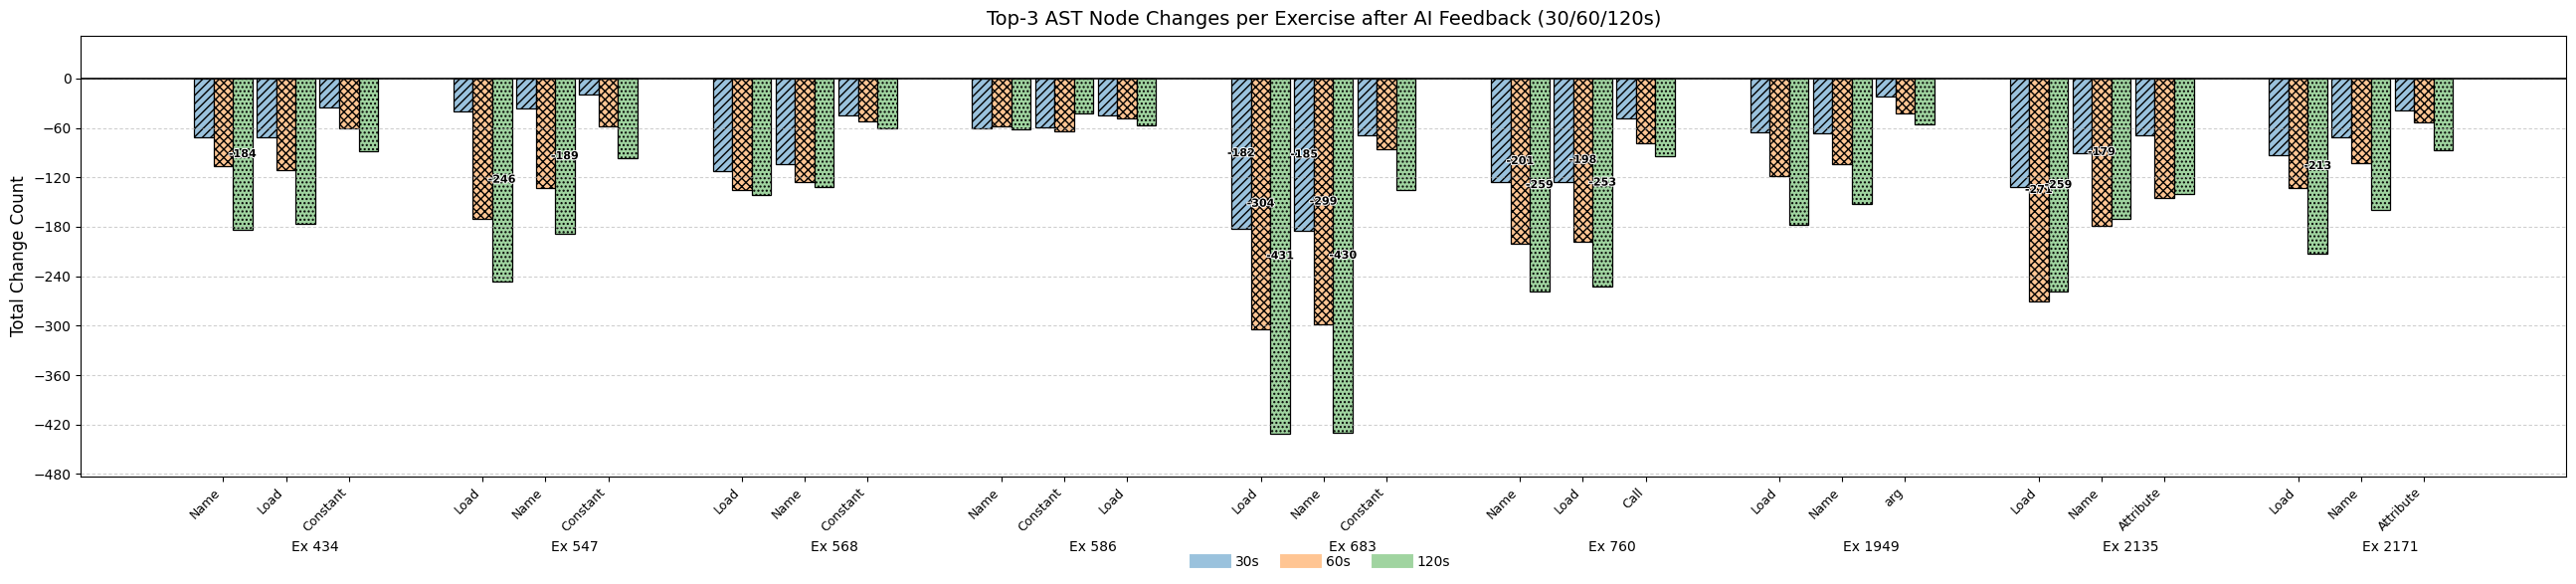

In [5]:
# --- prerequisites ---
import pandas as pd, numpy as np, ast
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# ========= 1) LOAD + NORMALIZE =========
survey_ex = [434, 547, 568, 586, 683, 760, 1949, 2135, 2171]

student_encoding_df = pd.read_csv("./dataset/student_encoding.csv")
student_encoding_dict = student_encoding_df.set_index('Student ID').T.to_dict('records')[0]

user_encryption_df = pd.read_csv('./dataset/user_encryptions.csv', sep=';')
user_encryption_dict = user_encryption_df.set_index('id').T.to_dict('records')[1]

# code snapshots
executed_codes_df  = pd.read_csv("./filtered_events_df/execute_code_events.csv")
saved_codes_df     = pd.read_csv("./filtered_events_df/save_code_events.csv")
submitted_codes_df = pd.read_csv("./filtered_events_df/submit_code_events.csv")
temporal_codes_df  = pd.concat([executed_codes_df, saved_codes_df, submitted_codes_df], ignore_index=True)
temporal_codes_df  = temporal_codes_df.dropna(subset=['Inserted Text'])
temporal_codes_df  = temporal_codes_df[temporal_codes_df["Exercise ID"].isin(survey_ex)].copy()
temporal_codes_df['Timestamp'] = pd.to_datetime(temporal_codes_df['Timestamp'])

# ai event markers from filtered_events_df
ai_events_df = pd.read_csv("./filtered_events_df/ai_feedback_events.csv")
ai_events_df["Student ID"] = ai_events_df["Student ID"].map(student_encoding_dict)
reverse_student_encoding_dict = {v: k for k, v in student_encoding_dict.items()}
ai_events_df["Student ID"] = ai_events_df["Student ID"].map(reverse_student_encoding_dict)
ai_events_df = ai_events_df[ai_events_df["Exercise ID"].isin(survey_ex)].copy()
ai_events_df['Timestamp'] = pd.to_datetime(ai_events_df['Timestamp'])

# raw AI calls (tabs file)
ai_calls_df = pd.read_csv('./dataset/ai_feedback_tabs.txt', sep='\t')
ai_calls_df["userId"] = ai_calls_df["userId"].map(user_encryption_dict)
ai_calls_df["userId"] = ai_calls_df["userId"].map(reverse_student_encoding_dict)
ai_calls_df['timestamp'] = pd.to_datetime(ai_calls_df['timestamp'])

# ========= 2) MATCH AI EVENTS TO RAW CALLS (nearest timestamp) =========
ai_events_sorted = ai_events_df.sort_values('Timestamp')
ai_calls_sorted  = ai_calls_df.sort_values('timestamp')
matched = pd.merge_asof(
    ai_events_sorted, ai_calls_sorted,
    left_on='Timestamp', right_on='timestamp',
    direction='nearest'
)

# prefer right-side exercise_id if present, else left
matched['exercise_id_final'] = matched['exercise_id'].fillna(matched['Exercise ID']).fillna(matched['Exercise ID'])
matched = matched.rename(columns={'code_latest_snapshot':'ai_code_sent'}).copy()

# ========= 3) PREP PARSABLE SNAPSHOTS PER EXERCISE =========
def is_parsable(s: str) -> bool:
    if not isinstance(s, str): 
        return False
    try:
        ast.parse(s)
        return True
    except Exception:
        return False

codes_clean = temporal_codes_df.copy()
codes_clean = codes_clean[codes_clean['Inserted Text'].apply(is_parsable)]
codes_clean['Timestamp'] = pd.to_datetime(codes_clean['Timestamp'], errors='coerce')
codes_clean = codes_clean.dropna(subset=['Timestamp'])
codes_clean = codes_clean.sort_values(['Exercise ID', 'Timestamp'])

per_ex_times = {}
per_ex_texts = {}
for ex, g in codes_clean.groupby('Exercise ID', sort=False):
    ts = g['Timestamp'].to_numpy(dtype='datetime64[ns]')  # homogeneous dtype
    per_ex_times[ex] = ts
    per_ex_texts[ex] = g['Inserted Text'].to_numpy()

# ========= 4) AST DIFF HELPERS =========
def parse_ast(s):
    try:
        return ast.parse(s) if isinstance(s, str) else None
    except Exception:
        return None

def ast_difference(ast_before, ast_after):
    if ast_before is None or ast_after is None:
        return {}
    b = Counter(type(n).__name__ for n in ast.walk(ast_before))
    a = Counter(type(n).__name__ for n in ast.walk(ast_after))
    diff = {k: a.get(k, 0) - b.get(k, 0) for k in set(b) | set(a)}
    return {k: v for k, v in diff.items() if v != 0}

# ========= 5) BUILD AGGREGATES: per-exercise, per-delta =========
deltas = [30, 60, 120]
agg_by_ex = {ex: {30: Counter(), 60: Counter(), 120: Counter()} for ex in survey_ex}

for row in matched.itertuples(index=False):
    ex = int(row.exercise_id_final) if not pd.isna(row.exercise_id_final) else int(row._asdict()['Exercise ID'])
    if ex not in per_ex_times: 
        continue

    base_ast = parse_ast(row.ai_code_sent)
    tseries = per_ex_times[ex]
    texts   = per_ex_texts[ex]

    ai_t64 = np.datetime64(pd.to_datetime(row.timestamp).to_datetime64())

    for d in deltas:
        target64 = ai_t64 + np.timedelta64(d, 's')
        tseries = per_ex_times[ex]  # dtype datetime64[ns]
        idx = np.searchsorted(tseries, target64, side='left')
        if idx >= len(tseries):
            continue
        after_ast = parse_ast(per_ex_texts[ex][idx])
        diff = ast_difference(base_ast, after_ast)
        if diff:
            agg_by_ex[ex][d].update(diff)

# ========= 6) PICK TOP-3 NODE TYPES PER EXERCISE (by total |change|) =========
top3_nodes_by_ex = {}
for ex in survey_ex:
    tot = Counter()
    for d in deltas:
        tot.update({k: abs(v) for k, v in agg_by_ex[ex][d].items()})
    top3_nodes_by_ex[ex] = [k for k, _ in tot.most_common(3)]

# ========= 7) PLOT: 9 groups × 3 nodes, each node with 3 bars =========
def _lighten(color, amount=0.45):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount * r, (1 - amount) + amount * g, (1 - amount) + amount * b

def plot_top3_by_ex(agg_by_ex, top3_nodes_by_ex, figsize=(24, 6)):
    base = {30: "#1f77b4", 60: "#ff7f0e", 120: "#2ca02c"}
    colors = {d: _lighten(base[d], amount=0.45) for d in deltas}
    hatches = {30: "////", 60: "xxxx", 120: "...."}

    bar_w = 0.22
    node_sep = 0.05
    group_sep = 0.8

    # build x positions
    x_positions = []
    x_labels    = []
    group_centers = []
    cur_x = 0.0

    for ex in survey_ex:
        nodes = top3_nodes_by_ex[ex]
        # center of this group across 3 nodes
        start_x = cur_x
        for node in nodes:
            # three bars within a node: offset -bar_w, 0, +bar_w
            x_positions.append((ex, node, {30: cur_x - bar_w, 60: cur_x, 120: cur_x + bar_w}))
            x_labels.append((cur_x, node))
            cur_x += (bar_w * 3 + node_sep)  # move to next node block
        end_x = cur_x - node_sep
        group_centers.append(((start_x + end_x) / 2.0, ex))
        cur_x += group_sep  # gap between exercises

    fig, ax = plt.subplots(figsize=figsize)

    # gather all heights to set ylim and thresholded labels
    all_vals = []

    # draw bars
    for (ex, node, xpos_map) in x_positions:
        for d in deltas:
            height = agg_by_ex[ex][d].get(node, 0)
            all_vals.append(height)
            ax.bar(
                xpos_map[d], height, width=bar_w,
                color=colors[d], hatch=hatches[d],
                edgecolor='black', linewidth=0.9
            )

    # x tick labels = node names, rotated; group labels = exercise ids under axis
    ax.set_xticks([x for (x, lbl) in x_labels])
    ax.set_xticklabels([lbl for (x, lbl) in x_labels], rotation=45, ha='right', fontsize=9)

    # secondary group labels
    y_min, y_max = (min(all_vals + [0]), max(all_vals + [0]))
    span = max(1, y_max - y_min)
    ax.set_ylim(y_min - 0.12 * span, y_max + 0.12 * span)
    ax.axhline(0, color='black', linewidth=1.2)
    ax.grid(axis="y", linestyle=(0, (3, 2)), linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    ax.set_ylabel("Total Change Count", fontsize=12)
    ax.set_title("Top-3 AST Node Changes per Exercise after AI Feedback (30/60/120s)", fontsize=14, pad=8)

    # exercise group labels
    for xc, ex in group_centers:
        ax.text(xc, ax.get_ylim()[0] - 0.18 * span, f"Ex {ex}", ha='center', va='top', fontsize=10)

    # numeric labels on large bars only
    mag = np.array([abs(v) for v in all_vals]) if all_vals else np.array([0])
    thr = max(3, np.percentile(mag, 80))
    for bar in ax.patches:
        h = bar.get_height()
        if abs(h) >= thr:
            x = bar.get_x() + bar.get_width() / 2.0
            y = bar.get_y() + h / 2.0
            ax.text(x, y, f"{int(h)}", ha="center", va="center", fontsize=8, fontweight="bold",
                    path_effects=[pe.withStroke(linewidth=1.4, foreground="white")])

    # legend
    from matplotlib.lines import Line2D
    handles = [Line2D([0], [0], color=colors[d], lw=10, label=f"{d}s", linestyle="-") for d in deltas]
    ax.legend(handles=handles, ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.15),
              frameon=False, fontsize=10)

    fig.tight_layout()
    return fig, ax

fig, ax = plot_top3_by_ex(agg_by_ex, top3_nodes_by_ex, figsize=(26, 6))
fig.savefig("plots/ast_top3_by_exercises.png", dpi=300, bbox_inches="tight")
plt.show()


In [72]:
# ========= 6) PLOT ALL NODES, ONE FIGURE PER EXERCISE =========
import os
os.makedirs("plots", exist_ok=True)

def _lighten(color, amount=0.45):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount * r, (1 - amount) + amount * g, (1 - amount) + amount * b

def _sorted_nodes_all(agg_for_ex: dict) -> list[str]:
    tot = Counter()
    for d in deltas:
        tot.update({k: abs(v) for k, v in agg_for_ex[d].items()})
    # keep nodes that ever changed; sort by |change| desc, then name
    nodes = [k for k, v in tot.most_common() if v != 0]
    return nodes

def plot_all_nodes_for_exercises(agg_by_ex: dict, survey_ex: list[int]):
    base = {30: "#1f77b4", 60: "#ff7f0e", 120: "#2ca02c"}
    colors = {d: _lighten(base[d], amount=0.45) for d in deltas}
    hatches = {30: "////", 60: "xxxx", 120: "...."}

    for ex in survey_ex:
        nodes = _sorted_nodes_all(agg_by_ex[ex])
        if not nodes:  # nothing changed for this exercise
            nodes = []

        # width scales with node count
        n = max(1, len(nodes))
        fig_w = min(36, max(10, 0.45 * n + 6))  # cap very large
        fig, ax = plt.subplots(figsize=(fig_w, 6))

        bar_w = 0.25
        x = np.arange(n)

        all_vals = []
        for i, d in enumerate(deltas):
            vals = [agg_by_ex[ex][d].get(nt, 0) for nt in nodes]
            all_vals.extend(vals)
            ax.bar(
                x + i * bar_w, vals, width=bar_w,
                color=colors[d], hatch=hatches[d],
                edgecolor="black", linewidth=0.9, label=f"{d}s"
            )

        ax.set_xticks(x + bar_w)
        ax.set_xticklabels(nodes, rotation=45, ha="right", fontsize=9)
        ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
        ax.grid(axis="y", linestyle=(0, (3, 2)), linewidth=0.8, alpha=0.6)
        ax.axhline(0, color="black", linewidth=1.2)
        ax.set_xlabel("AST Node Types", fontsize=12)
        ax.set_ylabel("Total Change Count", fontsize=12)
        ax.set_title(f"Exercise {ex}: AST Node Changes after AI Feedback (30/60/120s)", fontsize=14, pad=8)

        if all_vals:
            lo, hi = min(all_vals), max(all_vals)
            span = max(1, hi - lo)
            ax.set_ylim(lo - 0.12 * span, hi + 0.12 * span)
        else:
            span = 1

        # numeric labels on prominent bars only
        mag = np.array([abs(v) for v in all_vals]) if all_vals else np.array([0])
        thr = max(3, np.percentile(mag, 80)) if all_vals else 0
        for rect in ax.patches:
            h = rect.get_height()
            if abs(h) >= thr and h != 0:
                x_pos = rect.get_x() + rect.get_width() / 2.0
                y_pos = rect.get_y() + h / 2.0
                ax.text(
                    x_pos, y_pos, f"{int(h)}",
                    ha="center", va="center", fontsize=8, fontweight="bold",
                    path_effects=[pe.withStroke(linewidth=1.4, foreground="white")]
                )

        ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.15),
                  frameon=False, fontsize=10)
        fig.tight_layout()
        out = f"plots/ast_nodes_ex_{ex}.png"
        fig.savefig(out, dpi=300, bbox_inches="tight")
        plt.close(fig)

# run
plot_all_nodes_for_exercises(agg_by_ex, survey_ex)


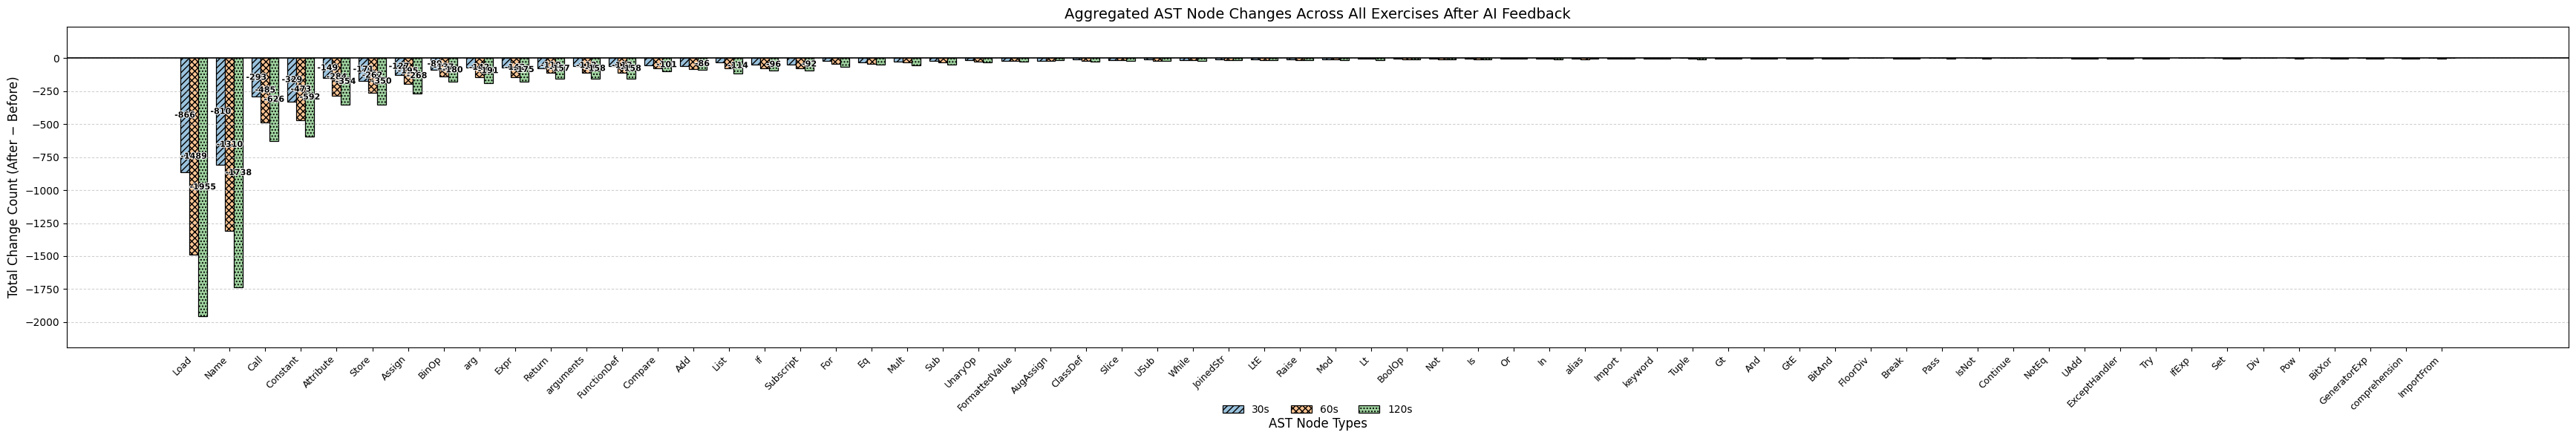

In [73]:
# ========= AGGREGATE ACROSS ALL EXERCISES, ONE PLOT =========
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import os

deltas = [30, 60, 120]

# 1) Sum counters over all exercises
combined = {30: Counter(), 60: Counter(), 120: Counter()}
for ex_dict in agg_by_ex.values():
    for d in deltas:
        combined[d].update(ex_dict[d])

# 2) Node order = by total absolute change desc
tot_abs = Counter()
for d in deltas:
    tot_abs.update({k: abs(v) for k, v in combined[d].items()})
node_types = [k for k, v in tot_abs.most_common() if v != 0]  # all nodes that changed

# 3) Plot
def _lighten(color, amount=0.45):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount * r, (1 - amount) + amount * g, (1 - amount) + amount * b

base = {30: "#1f77b4", 60: "#ff7f0e", 120: "#2ca02c"}
colors = {d: _lighten(base[d], amount=0.45) for d in deltas}
hatches = {30: "////", 60: "xxxx", 120: "...."}

n = max(1, len(node_types))
fig_w = min(36, max(12, 0.45 * n + 6))
fig, ax = plt.subplots(figsize=(fig_w, 6))

bar_w = 0.25
x = np.arange(n)

all_vals = []
for i, d in enumerate(deltas):
    vals = [combined[d].get(nt, 0) for nt in node_types]
    all_vals.extend(vals)
    ax.bar(
        x + i * bar_w, vals, width=bar_w,
        color=colors[d], hatch=hatches[d],
        edgecolor="black", linewidth=0.9, label=f"{d}s"
    )

ax.set_xticks(x + bar_w)
ax.set_xticklabels(node_types, rotation=45, ha="right", fontsize=9)
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.grid(axis="y", linestyle=(0, (3, 2)), linewidth=0.8, alpha=0.6)
ax.axhline(0, color="black", linewidth=1.2)
ax.set_xlabel("AST Node Types", fontsize=12)
ax.set_ylabel("Total Change Count (After − Before)", fontsize=12)
ax.set_title("Aggregated AST Node Changes Across All Exercises After AI Feedback", fontsize=14, pad=8)

if all_vals:
    lo, hi = min(all_vals), max(all_vals)
    span = max(1, hi - lo)
    ax.set_ylim(lo - 0.12 * span, hi + 0.12 * span)

# numeric labels on prominent bars
mag = np.array([abs(v) for v in all_vals]) if all_vals else np.array([0])
thr = max(3, np.percentile(mag, 80)) if all_vals else 0
for rect in ax.patches:
    h = rect.get_height()
    if abs(h) >= thr and h != 0:
        ax.text(
            rect.get_x() + rect.get_width()/2.0,
            rect.get_y() + h/2.0,
            f"{int(h)}",
            ha="center", va="center", fontsize=8, fontweight="bold",
            path_effects=[pe.withStroke(linewidth=1.4, foreground="white")]
        )

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.15),
          frameon=False, fontsize=10)

fig.tight_layout()
os.makedirs("plots", exist_ok=True)
fig.savefig("plots/ast_nodes_all_exercises.png", dpi=300, bbox_inches="tight")
plt.show()


## Seperate addition and subtractions

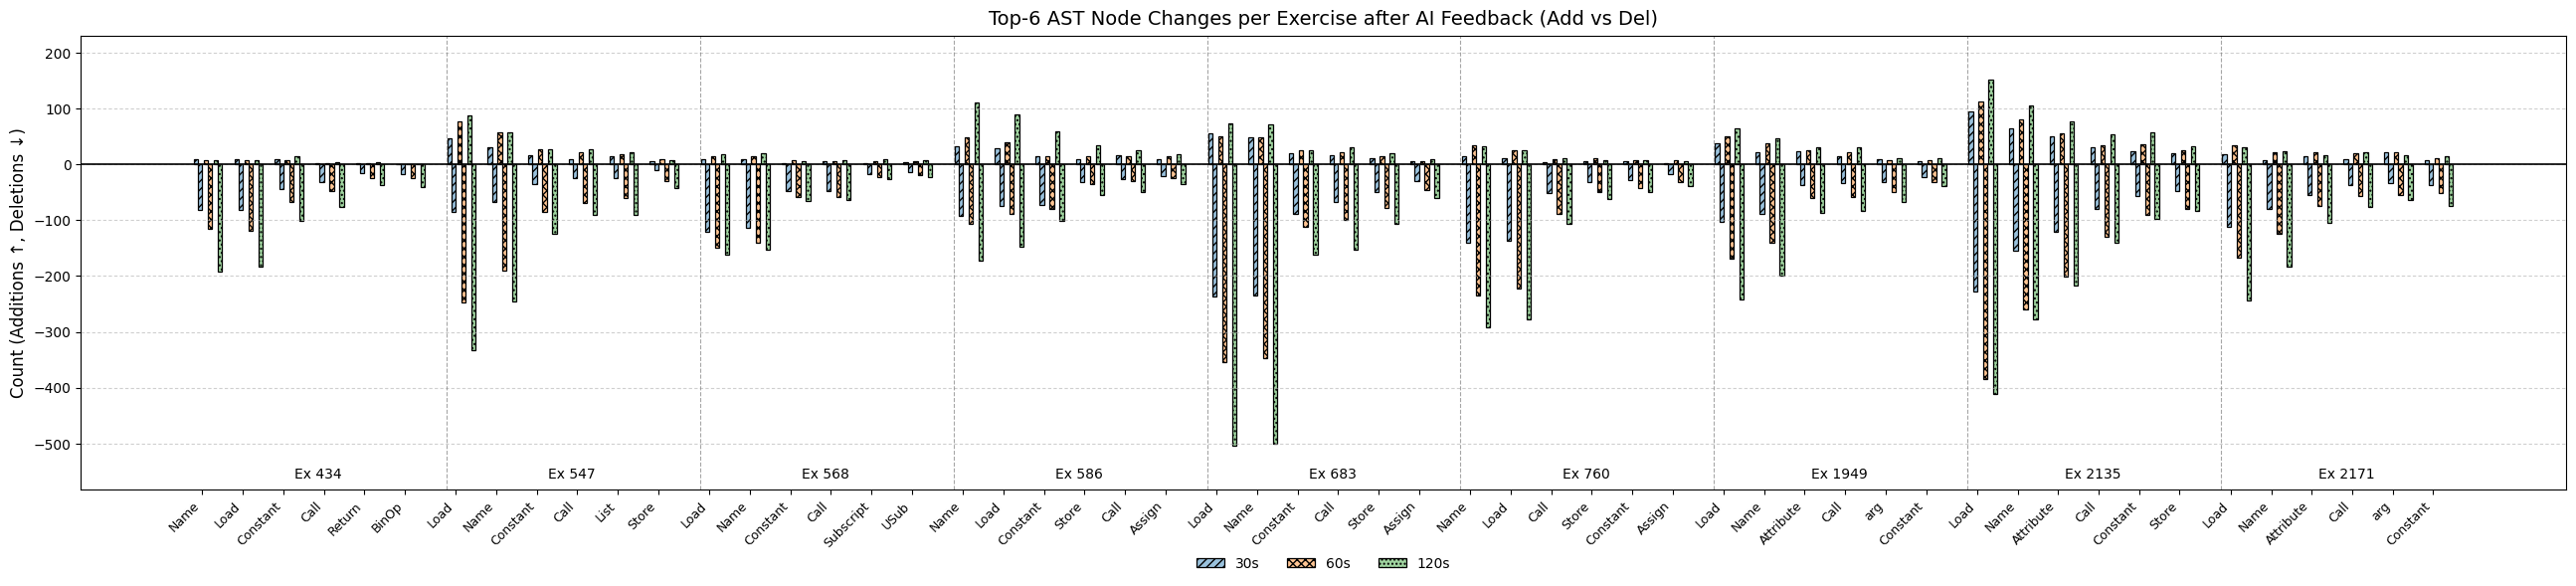

In [6]:
# --- prerequisites ---
import pandas as pd, numpy as np, ast
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe

# ========= 1) LOAD + NORMALIZE =========
survey_ex = [434, 547, 568, 586, 683, 760, 1949, 2135, 2171]

student_encoding_df = pd.read_csv("./dataset/student_encoding.csv")
student_encoding_dict = student_encoding_df.set_index('Student ID').T.to_dict('records')[0]

user_encryption_df = pd.read_csv('./dataset/user_encryptions.csv', sep=';')
user_encryption_dict = user_encryption_df.set_index('id').T.to_dict('records')[1]

# code snapshots
executed_codes_df  = pd.read_csv("./filtered_events_df/execute_code_events.csv")
saved_codes_df     = pd.read_csv("./filtered_events_df/save_code_events.csv")
submitted_codes_df = pd.read_csv("./filtered_events_df/submit_code_events.csv")
temporal_codes_df  = pd.concat([executed_codes_df, saved_codes_df, submitted_codes_df], ignore_index=True)
temporal_codes_df  = temporal_codes_df.dropna(subset=['Inserted Text'])
temporal_codes_df  = temporal_codes_df[temporal_codes_df["Exercise ID"].isin(survey_ex)].copy()
temporal_codes_df['Timestamp'] = pd.to_datetime(temporal_codes_df['Timestamp'])

# ai event markers from filtered_events_df
ai_events_df = pd.read_csv("./filtered_events_df/ai_feedback_events.csv")
ai_events_df["Student ID"] = ai_events_df["Student ID"].map(student_encoding_dict)
reverse_student_encoding_dict = {v: k for k, v in student_encoding_dict.items()}
ai_events_df["Student ID"] = ai_events_df["Student ID"].map(reverse_student_encoding_dict)
ai_events_df = ai_events_df[ai_events_df["Exercise ID"].isin(survey_ex)].copy()
ai_events_df['Timestamp'] = pd.to_datetime(ai_events_df['Timestamp'])

# raw AI calls (tabs file)
ai_calls_df = pd.read_csv('./dataset/ai_feedback_tabs.txt', sep='\t')
ai_calls_df["userId"] = ai_calls_df["userId"].map(user_encryption_dict)
ai_calls_df["userId"] = ai_calls_df["userId"].map(reverse_student_encoding_dict)
ai_calls_df['timestamp'] = pd.to_datetime(ai_calls_df['timestamp'])

# ========= 2) MATCH AI EVENTS TO RAW CALLS (nearest timestamp) =========
ai_events_sorted = ai_events_df.sort_values('Timestamp')
ai_calls_sorted  = ai_calls_df.sort_values('timestamp')
matched = pd.merge_asof(
    ai_events_sorted, ai_calls_sorted,
    left_on='Timestamp', right_on='timestamp',
    direction='nearest'
)

# prefer right-side exercise_id if present, else left
matched['exercise_id_final'] = matched['exercise_id'].fillna(matched['Exercise ID']).fillna(matched['Exercise ID'])
matched = matched.rename(columns={'code_latest_snapshot':'ai_code_sent'}).copy()

# ========= 3) PREP PARSABLE SNAPSHOTS PER EXERCISE =========
def is_parsable(s: str) -> bool:
    if not isinstance(s, str): 
        return False
    try:
        ast.parse(s)
        return True
    except Exception:
        return False

codes_clean = temporal_codes_df.copy()
codes_clean = codes_clean[codes_clean['Inserted Text'].apply(is_parsable)]
codes_clean['Timestamp'] = pd.to_datetime(codes_clean['Timestamp'], errors='coerce')
codes_clean = codes_clean.dropna(subset=['Timestamp'])
codes_clean = codes_clean.sort_values(['Exercise ID', 'Timestamp'])

per_ex_times = {}
per_ex_texts = {}
for ex, g in codes_clean.groupby('Exercise ID', sort=False):
    ts = g['Timestamp'].to_numpy(dtype='datetime64[ns]')  # homogeneous dtype
    per_ex_times[ex] = ts
    per_ex_texts[ex] = g['Inserted Text'].to_numpy()

# ========= 4) AST DIFF HELPERS =========
def parse_ast(s):
    try:
        return ast.parse(s) if isinstance(s, str) else None
    except Exception:
        return None

def ast_difference(ast_before, ast_after):
    if ast_before is None or ast_after is None:
        return {}
    b = Counter(type(n).__name__ for n in ast.walk(ast_before))
    a = Counter(type(n).__name__ for n in ast.walk(ast_after))
    diff = {k: a.get(k, 0) - b.get(k, 0) for k in set(b) | set(a)}
    return {k: v for k, v in diff.items() if v != 0}

# ========= 5) BUILD AGGREGATES: per-exercise, per-delta =========
# --- directional aggregates: additions vs deletions ---
deltas = [30, 60, 120]
agg_dir_by_ex = {
    ex: {30: {"add": Counter(), "del": Counter()},
         60: {"add": Counter(), "del": Counter()},
         120: {"add": Counter(), "del": Counter()}}
    for ex in survey_ex
}

for row in matched.itertuples(index=False):
    ex = int(row.exercise_id_final) if not pd.isna(row.exercise_id_final) else int(row._asdict()['Exercise ID'])
    if ex not in per_ex_times:
        continue

    base_ast = parse_ast(row.ai_code_sent)
    ai_t64   = np.datetime64(pd.to_datetime(row.timestamp).to_datetime64())
    tseries  = per_ex_times[ex]
    texts    = per_ex_texts[ex]

    if base_ast is None:
        continue

    b = Counter(type(n).__name__ for n in ast.walk(base_ast))

    for d in deltas:
        target64 = ai_t64 + np.timedelta64(d, 's')
        idx = np.searchsorted(tseries, target64, side='left')
        if idx >= len(tseries):
            continue

        after_ast = parse_ast(texts[idx])
        if after_ast is None:
            continue

        a = Counter(type(n).__name__ for n in ast.walk(after_ast))
        for k in set(a) | set(b):
            dv = a.get(k, 0) - b.get(k, 0)
            if dv > 0:
                agg_dir_by_ex[ex][d]["add"][k] += dv
            elif dv < 0:
                agg_dir_by_ex[ex][d]["del"][k] += -dv   # store magnitude only


# ========= 6) PICK TOP-3 NODE TYPES PER EXERCISE (by total |change|) =========
top3_nodes_by_ex = {}
for ex in survey_ex:
    tot = Counter()
    for d in deltas:
        tot.update({k: abs(v) for k, v in agg_by_ex[ex][d].items()})
    top3_nodes_by_ex[ex] = [k for k, _ in tot.most_common(6)]

# ========= 7) PLOT: 9 groups × 3 nodes, each node with 3 bars =========
def _lighten(color, amount=0.45):
    r, g, b = mcolors.to_rgb(color)
    return (1 - amount) + amount * r, (1 - amount) + amount * g, (1 - amount) + amount * b

def topk_nodes_by_ex_dir(agg_dir_by_ex, k=6):
    topk = {}
    for ex in survey_ex:
        tot = Counter()
        for d in deltas:
            for knt, v in agg_dir_by_ex[ex][d]["add"].items():
                tot[knt] += v
            for knt, v in agg_dir_by_ex[ex][d]["del"].items():
                tot[knt] += v
        topk[ex] = [knt for knt, _ in tot.most_common(k)]
    return topk

top3_nodes_by_ex = topk_nodes_by_ex_dir(agg_dir_by_ex, k=6)

def _lighten(c, amount=0.45):
    r,g,b = mcolors.to_rgb(c)
    return (1-amount)+amount*r, (1-amount)+amount*g, (1-amount)+amount*b

TOP_K = 6  # <-- change this number to get top-3, top-6, etc.

def topk_nodes_by_ex_dir(agg_dir_by_ex, k=TOP_K):
    topk = {}
    for ex in survey_ex:
        tot = Counter()
        for d in deltas:
            tot.update(agg_dir_by_ex[ex][d]["add"])
            tot.update(agg_dir_by_ex[ex][d]["del"])
        topk[ex] = [knt for knt, _ in tot.most_common(k)]
    return topk

topk_nodes_by_ex = topk_nodes_by_ex_dir(agg_dir_by_ex, k=TOP_K)

# ========= plotting function =========
def plot_topk_add_del_by_ex(agg_dir_by_ex, topk_nodes_by_ex, figsize=(26,6)):
    base   = {30:"#1f77b4", 60:"#ff7f0e", 120:"#2ca02c"}
    colors = {d:_lighten(base[d],0.45) for d in deltas}
    hatches= {30:"////", 60:"xxxx", 120:"...."}

    bar_w    = 0.6
    node_sep = 0.3
    grp_sep  = 1.5

    x_triplets, labels, centers, group_bounds = [], [], [], []
    x = 0.0

    for ex in survey_ex:
        nodes = topk_nodes_by_ex.get(ex, [])
        start = x
        for node in nodes:
            x_triplets.append((ex, node, {d: x + i*(bar_w*2+0.2) for i,d in enumerate(deltas)}))
            labels.append((x + bar_w, node))
            x += (bar_w*2+0.6)*len(deltas) + node_sep
        end = x
        centers.append(((start + end - node_sep)/2.0, ex))
        group_bounds.append(end + grp_sep/2.0)  # save right edge
        x += grp_sep

    fig, ax = plt.subplots(figsize=figsize)
    all_vals = []

    for ex, node, slot_x in x_triplets:
        for d in deltas:
            add_val = agg_dir_by_ex[ex][d]["add"].get(node, 0)
            del_val = -agg_dir_by_ex[ex][d]["del"].get(node, 0)
            all_vals.extend([add_val, del_val])
            ax.bar(slot_x[d]-bar_w/2, add_val, width=bar_w,
                   color=colors[d], hatch=hatches[d],
                   edgecolor='black', linewidth=0.9,
                   label=f"{d}s" if (ex==survey_ex[0] and node==topk_nodes_by_ex[survey_ex[0]][0]) else None)
            ax.bar(slot_x[d]+bar_w/2, del_val, width=bar_w,
                   color=colors[d], hatch=hatches[d],
                   edgecolor='black', linewidth=0.9)

    ax.set_xticks([p for p,_ in labels])
    ax.set_xticklabels([t for _,t in labels], rotation=45, ha='right', fontsize=9)

    lo, hi = (min(all_vals+[0]), max(all_vals+[0]))
    span = max(1, hi-lo)
    for xc, ex in centers:
        ax.text(xc, lo - 0.06*span, f"Ex {ex}", ha="center", va="top", fontsize=10)

    # add dashed vertical lines to separate exercises
    for gb in group_bounds[:-1]:  # skip last to avoid extra line at far right
        ax.axvline(gb, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)

    ax.axhline(0, color='black', linewidth=1.2)
    ax.grid(axis="y", linestyle=(0,(3,2)), linewidth=0.8, alpha=0.6)
    ax.set_ylim(lo-0.12*span, hi+0.12*span)
    ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    ax.set_ylabel("Count (Additions ↑, Deletions ↓)", fontsize=12)
    ax.set_title(f"Top-{TOP_K} AST Node Changes per Exercise after AI Feedback (Add vs Del)", fontsize=14, pad=8)

    ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5,-0.12),
              frameon=False, fontsize=10)
    fig.tight_layout()
    return fig, ax


# run
fig, ax = plot_topk_add_del_by_ex(agg_dir_by_ex, topk_nodes_by_ex, figsize=(26,6))
fig.savefig("plots/ast_topk_by_exercises.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import os

# ======== CONFIG ========
TOP_K = 6
EX_PER_FIG = 3
FIGSIZE = (30, 7)
TITLE_FONTSIZE = 24
LABEL_FONTSIZE = 24
TICK_FONTSIZE = 24
LEGEND_FONTSIZE = 24


# Skip these uninformative nodes
SKIP_NODES = {"Name", "Load", "Constant", "Store", "Attribute", "Call"}

# Fixed exercise order and ordinal labels
survey_ex = [586, 683, 760, 434, 568, 547, 2171, 1949, 2135]
ex_to_ord = {ex: i+1 for i, ex in enumerate(survey_ex)}  # 1..9 for E1..E9

# Delta settings
deltas  = [30, 60, 120]
def _lighten(c, amount=0.45):
    r,g,b = mcolors.to_rgb(c); return (1-amount)+amount*r, (1-amount)+amount*g, (1-amount)+amount*b
base    = {30:"#1f77b4", 60:"#e78127", 120:"#2ca02c"}
colors  = {d:_lighten(base[d],0.45) for d in deltas}
hatches = {30:"////", 60:"xxxx", 120:"...."}

# ======== TOP-K SELECTOR (excludes SKIP_NODES) ========
def topk_nodes_by_ex_dir(agg_dir_by_ex, k=TOP_K):
    topk = {}
    for ex in survey_ex:
        tot = Counter()
        for d in deltas:
            # add + del magnitudes
            tot.update({n:c for n,c in agg_dir_by_ex[ex][d]["add"].items() if n not in SKIP_NODES})
            tot.update({n:c for n,c in agg_dir_by_ex[ex][d]["del"].items() if n not in SKIP_NODES})
        # pick top-k among remaining nodes
        topk[ex] = [node for node,_ in tot.most_common(k)]
    return topk

topk_nodes_by_ex = topk_nodes_by_ex_dir(agg_dir_by_ex, k=TOP_K)

# ======== SINGLE SUBPLOT DRAWER ========
def draw_exercise_ax(ax, ex_id, nodes):
    bar_w   = 0.9
    gap_lr  = 0.25
    slot_w  = bar_w*2 + gap_lr
    node_gap = 0.8

    # build x positions
    x_positions = []
    x = 0.0
    for node in nodes:
        slot_centers = {}
        for i, d in enumerate(deltas):
            slot_centers[d] = x + i*(slot_w + 0.3)
        x_positions.append((node, slot_centers))
        x += slot_w*len(deltas) + node_gap

    # draw bars
    all_vals, tick_positions, tick_labels = [], [], []
    for node, slots in x_positions:
        for d in deltas:
            xc = slots[d]
            add_val = agg_dir_by_ex[ex_id][d]["add"].get(node, 0)
            del_val = -agg_dir_by_ex[ex_id][d]["del"].get(node, 0)
            all_vals.extend([add_val, del_val])

            ax.bar(xc - (gap_lr/2 + bar_w/2), add_val, width=bar_w,
                   color=colors[d], hatch=hatches[d], edgecolor="black", linewidth=0.9)
            ax.bar(xc + (gap_lr/2 + bar_w/2), del_val, width=bar_w,
                   color=colors[d], hatch=hatches[d], edgecolor="black", linewidth=0.9)

        mid = slots[deltas[1]]
        tick_positions.append(mid)
        tick_labels.append(node)

    # axes styling
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=TICK_FONTSIZE)
    ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    ax.grid(axis="y", linestyle=(0,(3,2)), linewidth=0.9, alpha=0.6)
    ax.axhline(0, color="black", linewidth=1.4)

    # Title uses ordinal label E1..E9 (no raw ID)
    ax.set_title(f"E{ex_to_ord[ex_id]}", fontsize=TITLE_FONTSIZE, pad=10)

    if all_vals:
        lo, hi = min(all_vals), max(all_vals)
        span = max(1, hi-lo)
        ax.set_ylim(lo - 0.12*span, hi + 0.12*span)
    ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

# ======== 3 FIGURES × 3 SUBPLOTS (1×3 EACH) ========
os.makedirs("plots", exist_ok=True)
groups = [survey_ex[i:i+EX_PER_FIG] for i in range(0, len(survey_ex), EX_PER_FIG)]

for gi, ex_group in enumerate(groups, start=1):
    fig, axes = plt.subplots(1, len(ex_group), figsize=FIGSIZE, constrained_layout=True)
    if len(ex_group) == 1:
        axes = [axes]

    for ax, ex_id in zip(axes, ex_group):
        nodes = topk_nodes_by_ex.get(ex_id, [])
        draw_exercise_ax(ax, ex_id, nodes)
        if ax is axes[0]:
            ax.set_ylabel("Count (Additions ↑, Deletions ↓)", fontsize=LABEL_FONTSIZE)

    handles = [
        Patch(facecolor=colors[d], hatch=hatches[d], edgecolor="black",
              label=f"{d}s", linewidth=0.9)
        for d in deltas
    ]
    fig.legend(handles=handles, loc="lower center", ncol=3,
               fontsize=LEGEND_FONTSIZE, frameon=False, bbox_to_anchor=(0.5, -0.08))

    # fig.suptitle(f"Top-{TOP_K} AST Node Changes after AI Feedback (Add vs Del)", fontsize=TITLE_FONTSIZE+2, y=1.1)
    out = f"plots/ast_add_del_top{TOP_K}_group_{gi}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    plt.close(fig)


## Heatmaps of KC vs Feedback

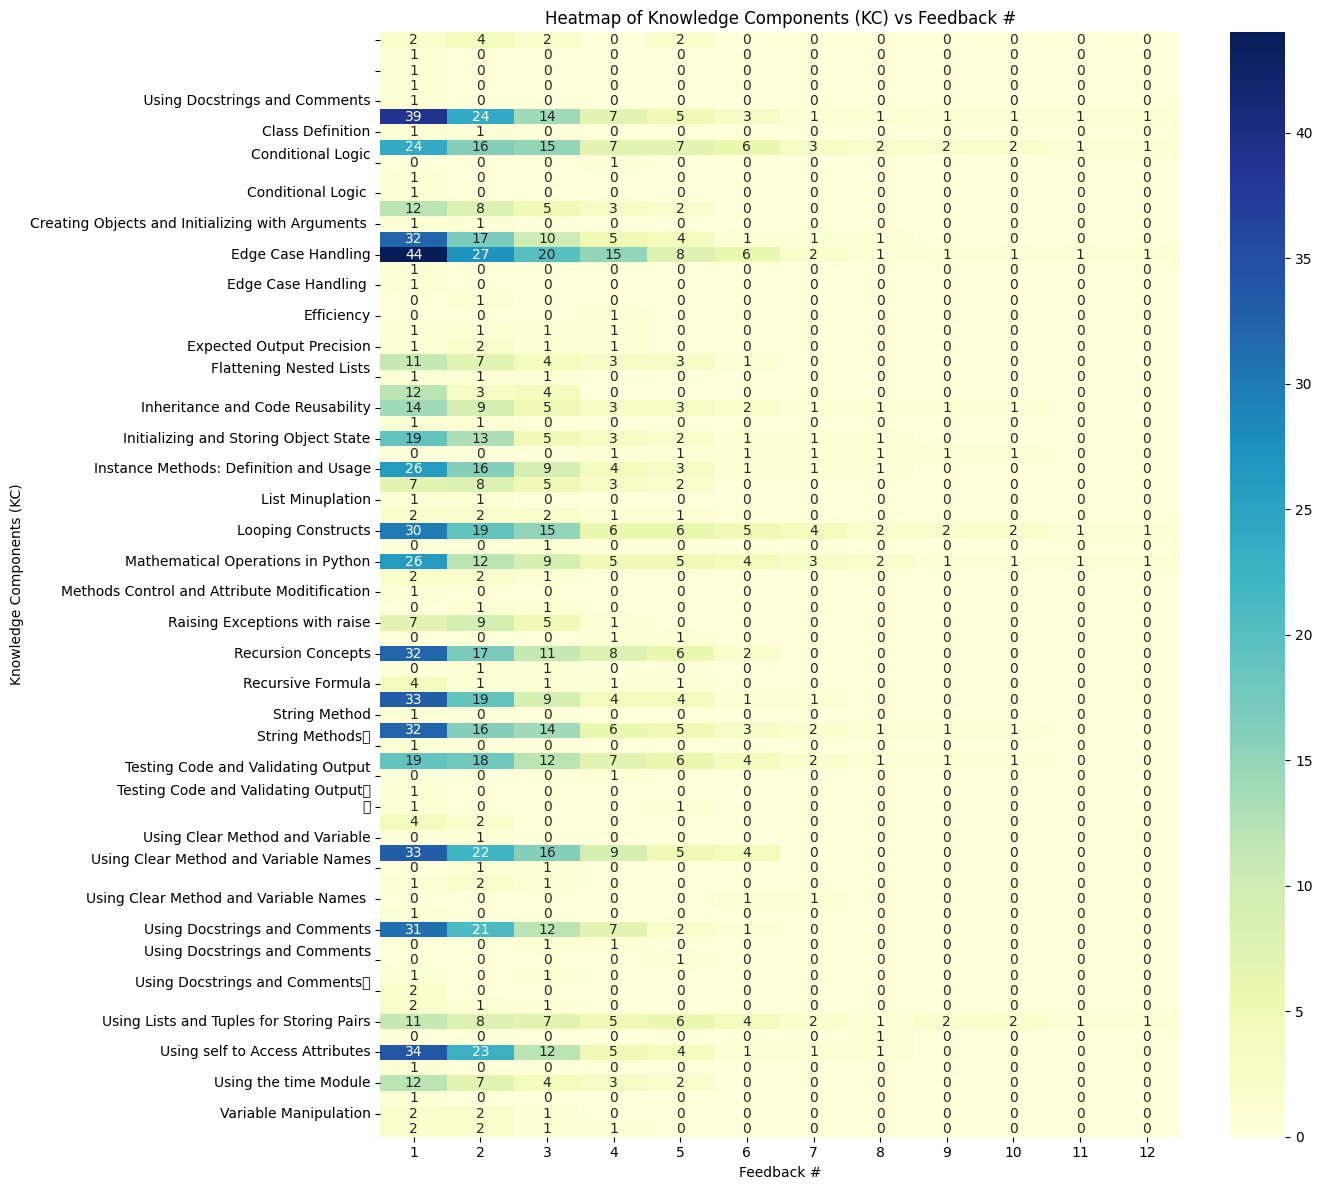

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Split KC Label column by commas and explode into separate rows
df_exploded = main_df.assign(**{"KC Label": main_df["KC Label"].str.split(", ")}).explode("KC Label")

# Create cross-tab (frequency table) of KC vs Feedback #
kc_feedback_matrix = pd.crosstab(df_exploded["KC Label"], df_exploded["Feedback #"])

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(kc_feedback_matrix, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Heatmap of Knowledge Components (KC) vs Feedback #")
plt.xlabel("Feedback #")
plt.ylabel("Knowledge Components (KC)")
plt.tight_layout()
plt.show()


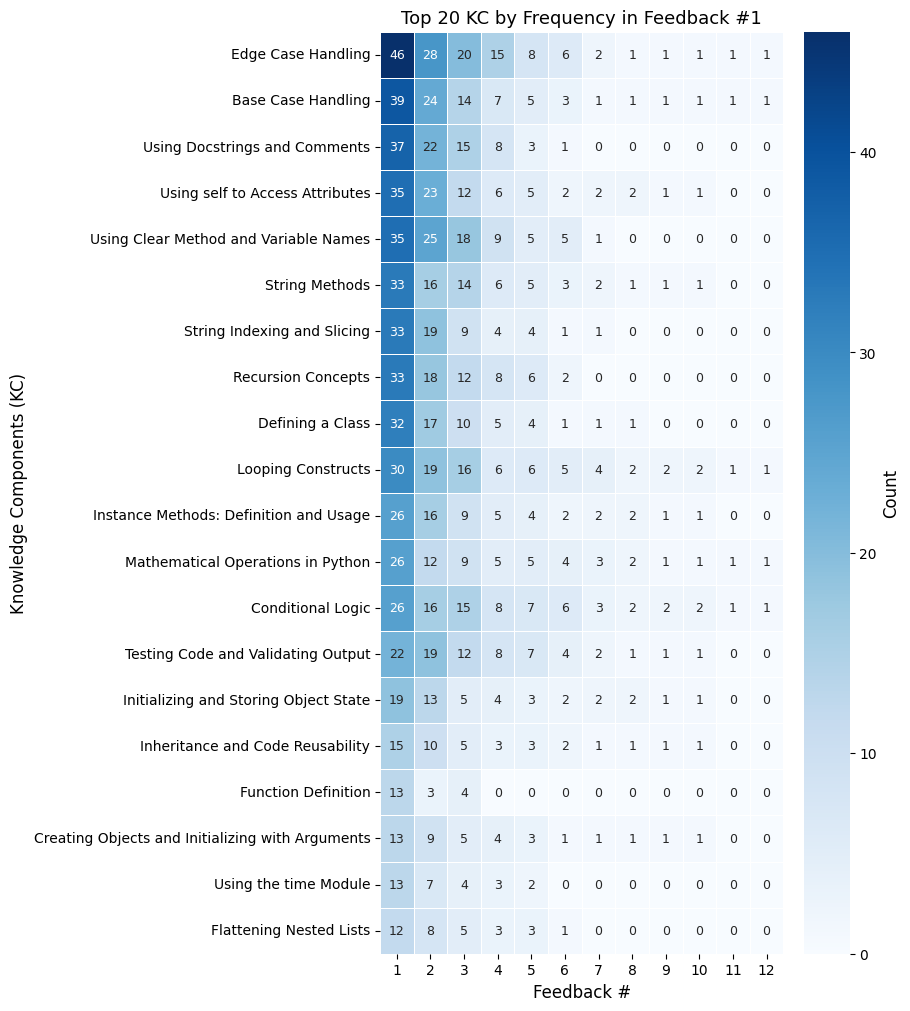

In [102]:
# --- KC × Feedback heatmap (paper-ready) ---
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- params ----------
k = 20                                # top-K KCs by count at Feedback #1
norm_rows = False                     # True -> row-wise % for distribution view
dpi = 600                             # export quality
font = 11                             # base font size

# ---------- prep ----------
mpl.rcParams.update({
    "font.size": font,
    "axes.titlesize": font+2,
    "axes.labelsize": font+1,
    "xtick.labelsize": font-1,
    "ytick.labelsize": font-1,
})

# explode multi-label KC column
df_exp = (
    main_df
    .assign(**{"KC Label": main_df["KC Label"].str.split(",")})
    .explode("KC Label")
)

# clean labels
df_exp["KC Label"] = (
    df_exp["KC Label"]
    .astype(str)
    .str.replace(r"[\t\n\r]+", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# cross-tab
ct = pd.crosstab(df_exp["KC Label"], df_exp["Feedback #"])

# keep KCs that appear at least once in Feedback #1
ct = ct[ct.get(1, pd.Series(0, index=ct.index)) > 0]

# enforce Feedback columns 1..max seen
cols = list(range(1, int(ct.columns.max())+1))
ct = ct.reindex(columns=cols, fill_value=0)

# pick top-K by Feedback #1
ct_top = ct.sort_values(by=1, ascending=False).head(k)

# optional row-wise normalization (percentages)
if norm_rows:
    denom = ct_top.sum(axis=1).replace(0, np.nan)
    ct_plot = (ct_top.div(denom, axis=0) * 100).round(1)
    annot_fmt = ".1f"
    cbar_label = "Row %"
else:
    ct_plot = ct_top.copy()
    annot_fmt = "d"
    cbar_label = "Count"

# annotations: NaN where value == 0 so Seaborn skips drawing text
ann = ct_plot.astype(float).mask(ct_plot.eq(0))

# numeric format
annot_fmt = ".1f" if norm_rows else ".0f"

# --- replace NaN with 0 in annotations ---
fig, ax = plt.subplots(figsize=(9, 10), constrained_layout=True)

# fill NaN with 0 for display but keep underlying heatmap values unchanged
ann_disp = ct_plot.copy()
ann_disp = ann_disp.round(1) if norm_rows else ann_disp.astype(int)
ann_disp = ann_disp.where(~ct_plot.isna(), 0)

sns.heatmap(
    ct_plot,
    ax=ax,
    cmap="Blues",                 # single gradient
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": cbar_label},
    annot=ann_disp,
    fmt=annot_fmt,
    annot_kws={"fontsize": font-2},
    square=False
)

ax.set_xlabel("Feedback #")
ax.set_ylabel("Knowledge Components (KC)")
ax.set_title(f"Top {len(ct_plot)} KC by Frequency in Feedback #1")

for label in ax.get_yticklabels():
    label.set_horizontalalignment("right")

plt.savefig("kc_feedback_heatmap.png", dpi=dpi, bbox_inches="tight")
plt.show()

## KC vs Students/Exercise

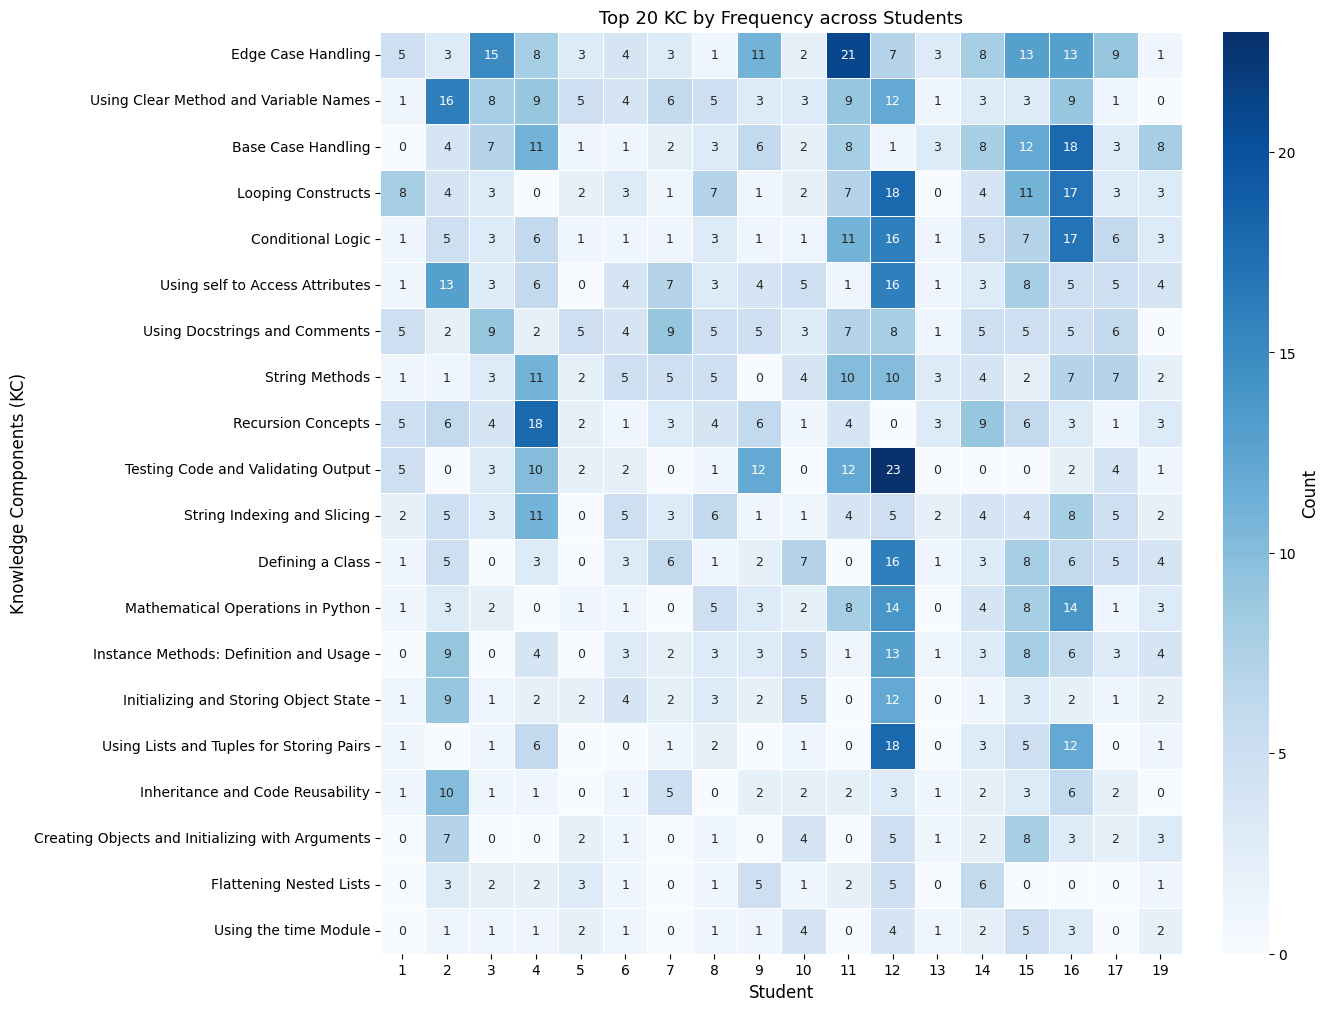

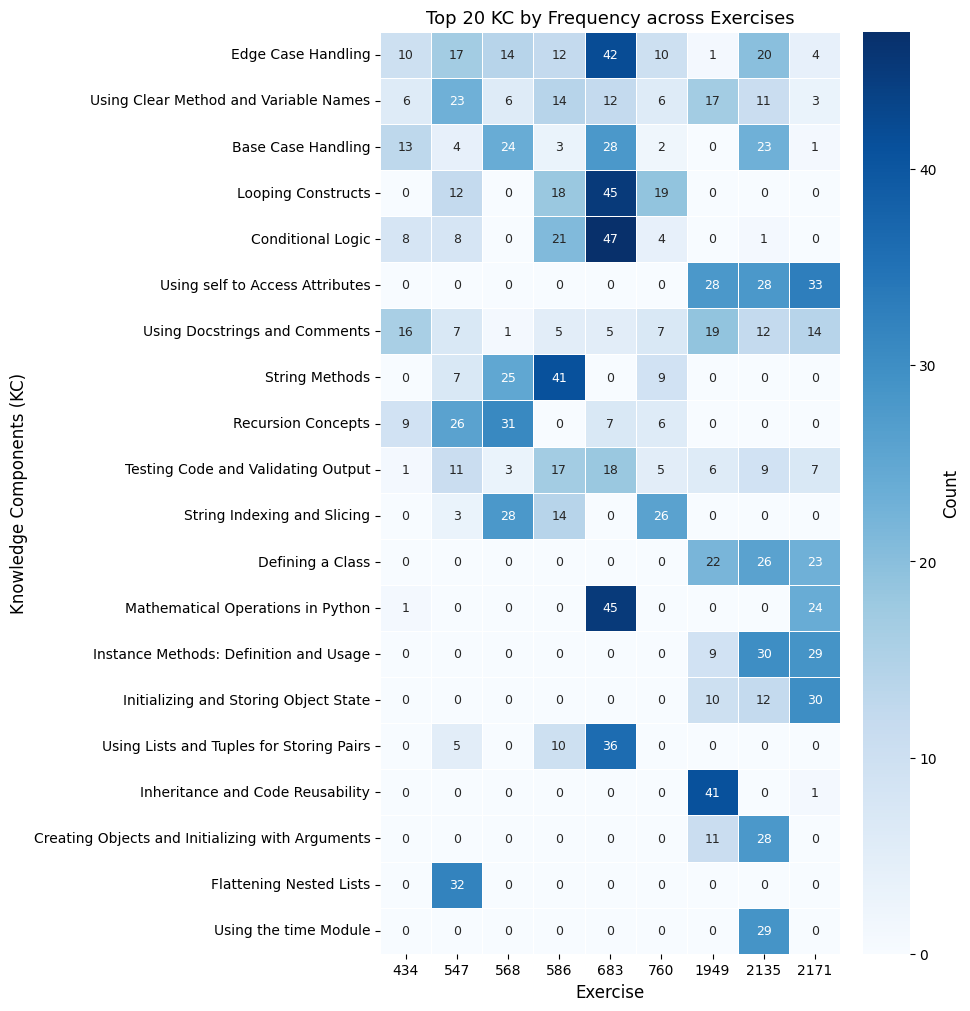

In [7]:
# --- KC × {Student, Exercise} heatmaps ---
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- params ----------
TOP_K = 20                 # number of KCs to display (by overall frequency)
NORM_ROWS = False          # True -> row-wise %
DPI = 600
FONT = 11

mpl.rcParams.update({
    "font.size": FONT,
    "axes.titlesize": FONT+2,
    "axes.labelsize": FONT+1,
    "xtick.labelsize": FONT-1,
    "ytick.labelsize": FONT-1,
})

# ---------- explode KC labels ----------
df_exp = (
    main_df
    .assign(**{"KC Label": main_df["KC Label"].str.split(",")})
    .explode("KC Label")
)

df_exp["KC Label"] = (
    df_exp["KC Label"]
    .astype(str)
    .str.replace(r"[\t\n\r]+", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

def _prep_ct(df: pd.DataFrame, axis_col: str) -> pd.DataFrame:
    """Cross-tab KC vs axis_col and keep TOP_K KCs by total count."""
    ct = pd.crosstab(df["KC Label"], df[axis_col])
    # sort axis col if numeric-like
    try:
        sorted_cols = sorted(ct.columns, key=lambda x: (float(x) if str(x).isdigit() else x))
        ct = ct.reindex(columns=sorted_cols)
    except Exception:
        ct = ct.sort_index(axis=1)
    # pick top-KCs by total occurrences across the axis
    ct = ct.assign(_tot=ct.sum(axis=1)).sort_values("_tot", ascending=False).drop(columns="_tot")
    return ct.head(TOP_K)

def _plot_heatmap(ct: pd.DataFrame, title: str, xlabel: str, outfile: str):
    if NORM_ROWS:
        denom = ct.sum(axis=1).replace(0, np.nan)
        ct_plot = (ct.div(denom, axis=0) * 100).round(1)
        annot_fmt = ".1f"
        cbar_label = "Row %"
    else:
        ct_plot = ct.copy()
        annot_fmt = "d"
        cbar_label = "Count"

    # annotations: display 0 for empty cells but keep heatmap values intact
    ann_disp = ct_plot.copy()
    ann_disp = ann_disp.round(1) if NORM_ROWS else ann_disp.astype(int)
    ann_disp = ann_disp.where(~ct_plot.isna(), 0)

    fig, ax = plt.subplots(figsize=(max(9, 0.4*len(ct_plot.columns)+6), 10), constrained_layout=True)
    sns.heatmap(
        ct_plot,
        ax=ax,
        cmap="Blues",
        linewidths=0.4,
        linecolor="white",
        cbar_kws={"label": cbar_label},
        annot=ann_disp,
        fmt=annot_fmt,
        annot_kws={"fontsize": FONT-2},
        square=False
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Knowledge Components (KC)")
    ax.set_title(title)
    for label in ax.get_yticklabels():
        label.set_horizontalalignment("right")
    plt.savefig(outfile, dpi=DPI, bbox_inches="tight")
    plt.show()

# ---------- KC × Student ----------
ct_student = _prep_ct(df_exp, "Student")
_plot_heatmap(
    ct_student,
    title=f"Top {len(ct_student)} KC by Frequency across Students",
    xlabel="Student",
    outfile="kc_student_heatmap.png",
)

# ---------- KC × Exercise ----------
ct_exercise = _prep_ct(df_exp, "Exercise")
_plot_heatmap(
    ct_exercise,
    title=f"Top {len(ct_exercise)} KC by Frequency across Exercises",
    xlabel="Exercise",
    outfile="kc_exercise_heatmap.png",
)


## Learning over the Course of Exercises

In [ ]:
error_col="Error Label"
exercise_col="Exercise"
student_col="Student"
exercise_order=(586, 683, 760, 434, 568, 547, 2171, 1949, 2135)

df_error = main_df.loc[main_df[exercise_col].isin(exercise_order), [student_col, exercise_col, error_col]].dropna(subset=[error_col]).copy()

# clean and split properly
df_error["Error Label"] = (
    df_error["Error Label"]
    .str.replace(" ", "")        # remove spaces
    .str.split(",")              # split by comma
)

# convert to binary columns
df_binary = df_error["Error Label"].str.join("|").str.get_dummies()

# join back
df_final = pd.concat([df_error[["Exercise", student_col]], df_binary], axis=1)

df_final.head()

,Exercise,Student,Efficiency,Logical,Syntax,Understandability
0,547,1,0,1,1,1
1,547,1,1,0,0,1
2,568,1,0,1,0,1
3,568,1,0,1,0,1
4,568,1,1,1,0,0


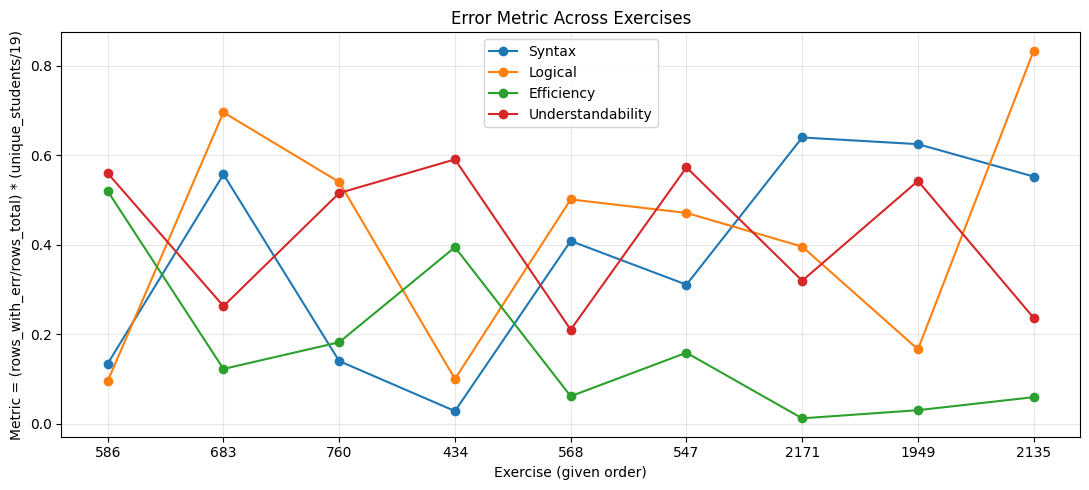

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TOTAL_STUDENTS = 19
exercise_order = (586, 683, 760, 434, 568, 547, 2171, 1949, 2135)
error_cols = ["Syntax", "Logical", "Understandability", "Efficiency"]

# ensure types
df_final = df_final.copy()
df_final["Exercise"] = pd.to_numeric(df_final["Exercise"], errors="coerce")

# totals per exercise
total_rows = df_final.groupby("Exercise").size().rename("total")

def metric_for(col):
    g = df_final[df_final[col] == 1]
    rows_err = g.groupby("Exercise").size().rename("rows_err")
    uniq_students = g.groupby("Exercise")["Student"].nunique().rename("uniq")
    out = pd.concat([total_rows, rows_err, uniq_students], axis=1).fillna(0)
    return (out["rows_err"] / out["total"]) * (out["uniq"] / TOTAL_STUDENTS)

metrics = {c: metric_for(c) for c in error_cols}

# fixed order, evenly spaced positions
order = list(exercise_order)
pos = np.arange(len(order))
plot_df = pd.DataFrame({k: v.reindex(order).fillna(0.0) for k, v in metrics.items()})

fig, ax = plt.subplots(figsize=(11, 5))
for col in ["Syntax", "Logical", "Efficiency", "Understandability"]:
    ax.plot(pos, plot_df[col].values, marker="o", label=col)

ax.set_xticks(pos, [str(x) for x in order])
ax.set_xlabel("Exercise (given order)")
ax.set_ylabel("Metric = (rows_with_err/rows_total) * (unique_students/19)")
ax.set_title("Error Metric Across Exercises")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


In [59]:
import pandas as pd

exercise_order = (586, 683, 760, 434, 568, 547, 2171, 1949, 2135)
error_col = "KC Label"
exercise_col = "Exercise"
student_col = "Student"

# Filter relevant exercises and drop missing KC
df_kc = main_df.loc[main_df[exercise_col].isin(exercise_order), 
                    [student_col, exercise_col, error_col]].dropna(subset=[error_col]).copy()

# Split KC labels into lists
df_kc[error_col] = df_kc[error_col].str.split(",").apply(lambda x: [i.strip() for i in x])

# Convert to binary indicator columns
df_kc_bin = df_kc[error_col].str.join("|").str.get_dummies()

# Join with Student and Exercise columns
df_kc_final = pd.concat([df_kc[[student_col, exercise_col]], df_kc_bin], axis=1)

df_kc_final

,Student,Exercise,Base Case Handling,Conditional Logic,Creating Objects and Initializing with Arguments,Defining a Class,Edge Case Handling,Encapsulation in Classes,Expected Output Precision,Flattening Nested Lists,...,String Indexing and Slicing,String Methods,Testing Code and Validating Output,Using Clear Method and Variable Names,Using Docstrings and Comments,Using Lists and Tuples for Storing Pairs,Using self to Access Attributes,Using the time Module,Variable Manipulation,Verifying Method Functionality
0,1,547,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,547,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,568,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,1,568,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,568,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,19,760,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
367,19,1949,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
368,19,2135,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
369,19,2135,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


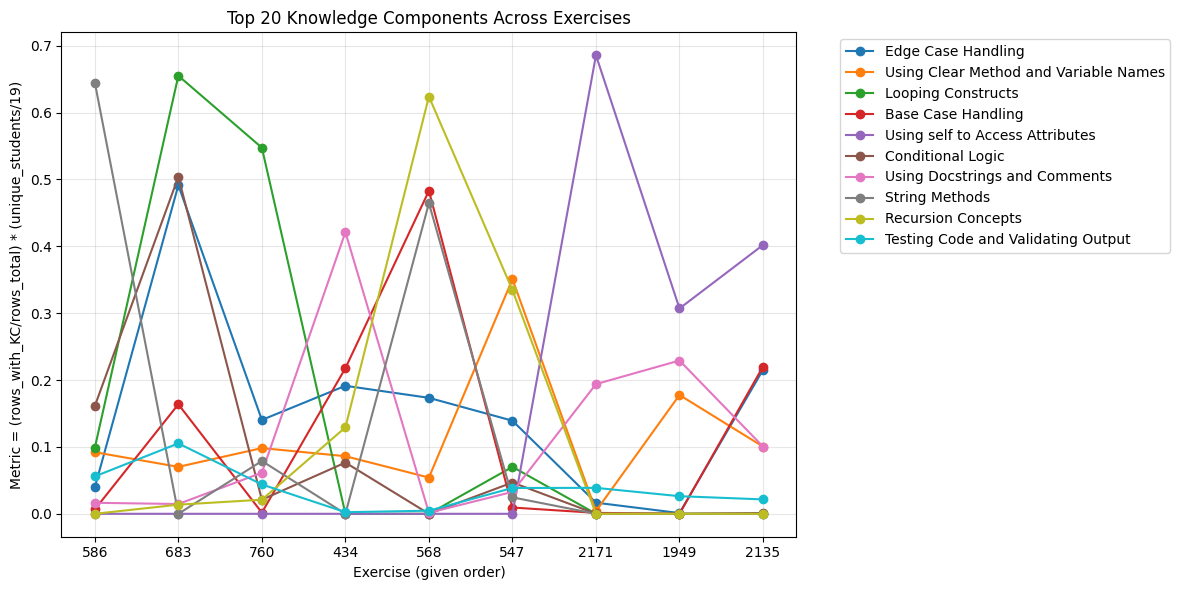

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TOTAL_STUDENTS = 19
exercise_order = (586, 683, 760, 434, 568, 547, 2171, 1949, 2135)

# --- Step 1: prepare KC dataframe as binary indicators ---
df_kc = main_df.loc[main_df["Exercise"].isin(exercise_order),
                    ["Student", "Exercise", "KC Label"]].dropna(subset=["KC Label"]).copy()

df_kc["KC Label"] = df_kc["KC Label"].str.split(",").apply(lambda x: [i.strip() for i in x])
df_kc_bin = df_kc["KC Label"].str.join("|").str.get_dummies()

df_kc_final = pd.concat([df_kc[["Student", "Exercise"]], df_kc_bin], axis=1)

# --- Step 2: select top-20 KCs by overall frequency ---
kc_counts = df_kc_bin.sum().sort_values(ascending=False)
top20_kcs = kc_counts.head(10).index.tolist()

# --- Step 3: compute metric per KC × exercise ---
total_rows = df_kc_final.groupby("Exercise").size().rename("total")

def metric_for(col):
    g = df_kc_final[df_kc_final[col] == 1]
    rows_err = g.groupby("Exercise").size().rename("rows_err")
    uniq_students = g.groupby("Exercise")["Student"].nunique().rename("uniq")
    out = pd.concat([total_rows, rows_err, uniq_students], axis=1).fillna(0)
    return (out["rows_err"] / out["total"]) * (out["uniq"] / TOTAL_STUDENTS)

metrics = {kc: metric_for(kc) for kc in top20_kcs}

# --- Step 4: assemble dataframe in fixed exercise order ---
order = list(exercise_order)
pos = np.arange(len(order))
plot_df = pd.DataFrame({k: v.reindex(order).fillna(0.0) for k, v in metrics.items()})

# --- Step 5: plot ---
fig, ax = plt.subplots(figsize=(12, 6))
for kc in top20_kcs:
    ax.plot(pos, plot_df[kc].values, marker="o", label=kc)

ax.set_xticks(pos, [str(x) for x in order])
ax.set_xlabel("Exercise (given order)")
ax.set_ylabel("Metric = (rows_with_KC/rows_total) * (unique_students/19)")
ax.set_title("Top 20 Knowledge Components Across Exercises")
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # put legend outside
plt.tight_layout()
plt.show()

## Non-Normalized KC and Syntax

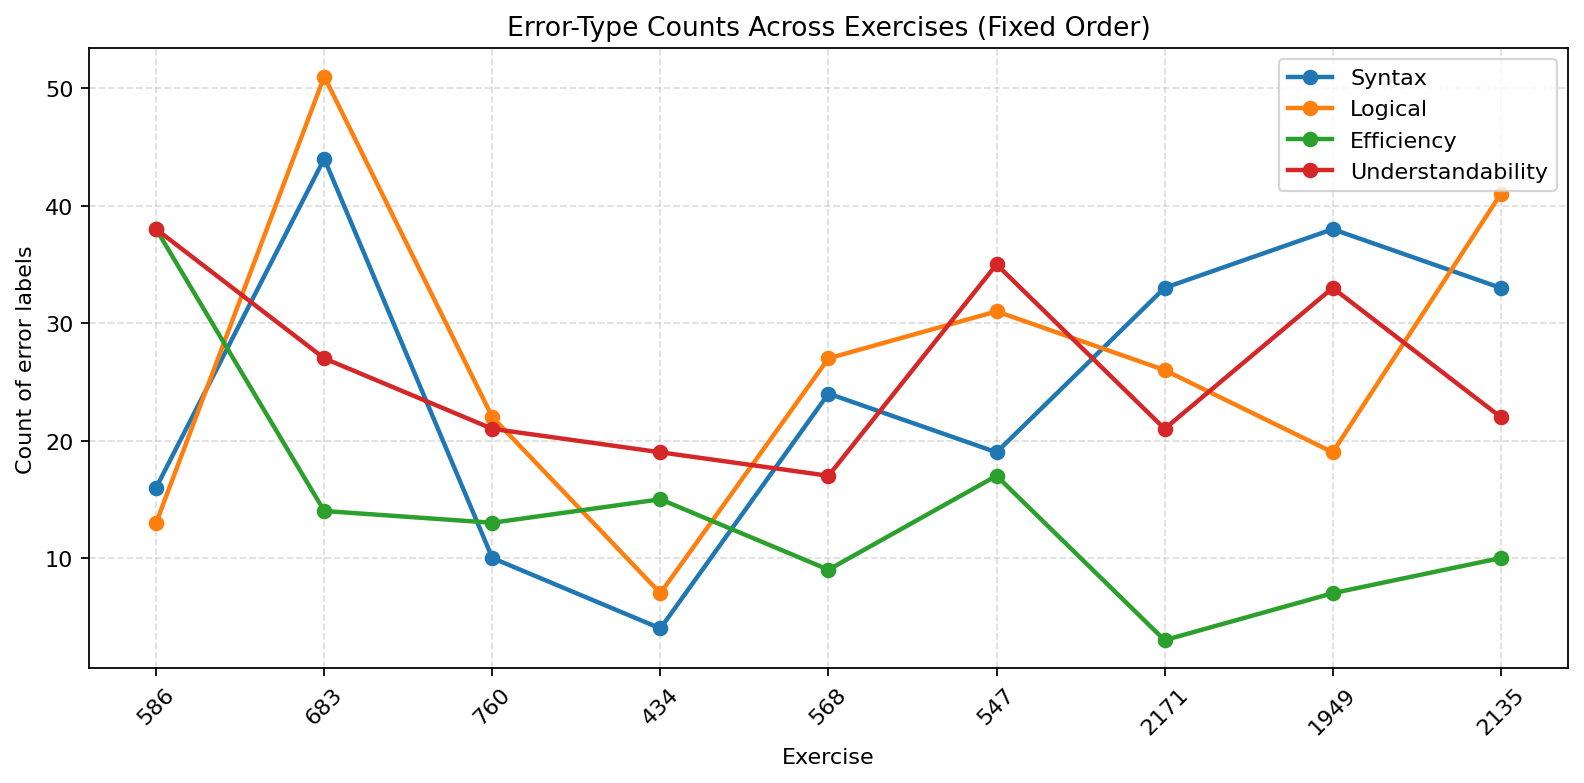

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_error_trajectories(main_df: pd.DataFrame,
                            exercise_order=(586, 683, 760, 434, 568, 547, 2171, 1949, 2135),
                            error_col="Error Label",
                            exercise_col="Exercise"):
    # standardize and explode comma-separated labels
    df = main_df.loc[main_df[exercise_col].isin(exercise_order), [exercise_col, error_col]].dropna(subset=[error_col]).copy()
    df["label"] = df[error_col].astype(str).str.split(",")
    df = df.explode("label")
    df["label"] = df["label"].str.strip().str.lower()

    # typo/casing normalization
    norm = {
        "syntax": "Syntax",
        "logical": "Logical",
        "efficiency": "Efficiency",
        "understadability": "Understandability",
        "understandability": "Understandability",
    }
    df["label"] = df["label"].map(lambda s: norm.get(s, s.title()))

    # aggregate counts per exercise × label
    counts = (
        df.groupby([exercise_col, "label"])
          .size()
          .unstack(fill_value=0)
          .reindex(exercise_order)
          .rename_axis("Exercise")
    )

    # ensure the four curves exist, in fixed order
    ordered_cols = ["Syntax", "Logical", "Efficiency", "Understandability"]
    for c in ordered_cols:
        if c not in counts.columns:
            counts[c] = 0
    counts = counts[ordered_cols]

    order = [586, 683, 760, 434, 568, 547, 2171, 1949, 2135]
    counts = counts.reindex(order)

    fig, ax = plt.subplots(figsize=(10,5), dpi=160)
    x = range(len(order))  # force left-to-right positions

    for col in ["Syntax", "Logical", "Efficiency", "Understandability"]:
        ax.plot(x, counts[col].values, marker="o", linewidth=2, label=col)

    ax.set_xticks(x)
    ax.set_xticklabels(order, rotation=45)
    ax.set_xlabel("Exercise")
    ax.set_ylabel("Count of error labels")
    ax.set_title("Error-Type Counts Across Exercises (Fixed Order)")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return counts  # optional: inspect exact values

# usage
counts_df = plot_error_trajectories(main_df)


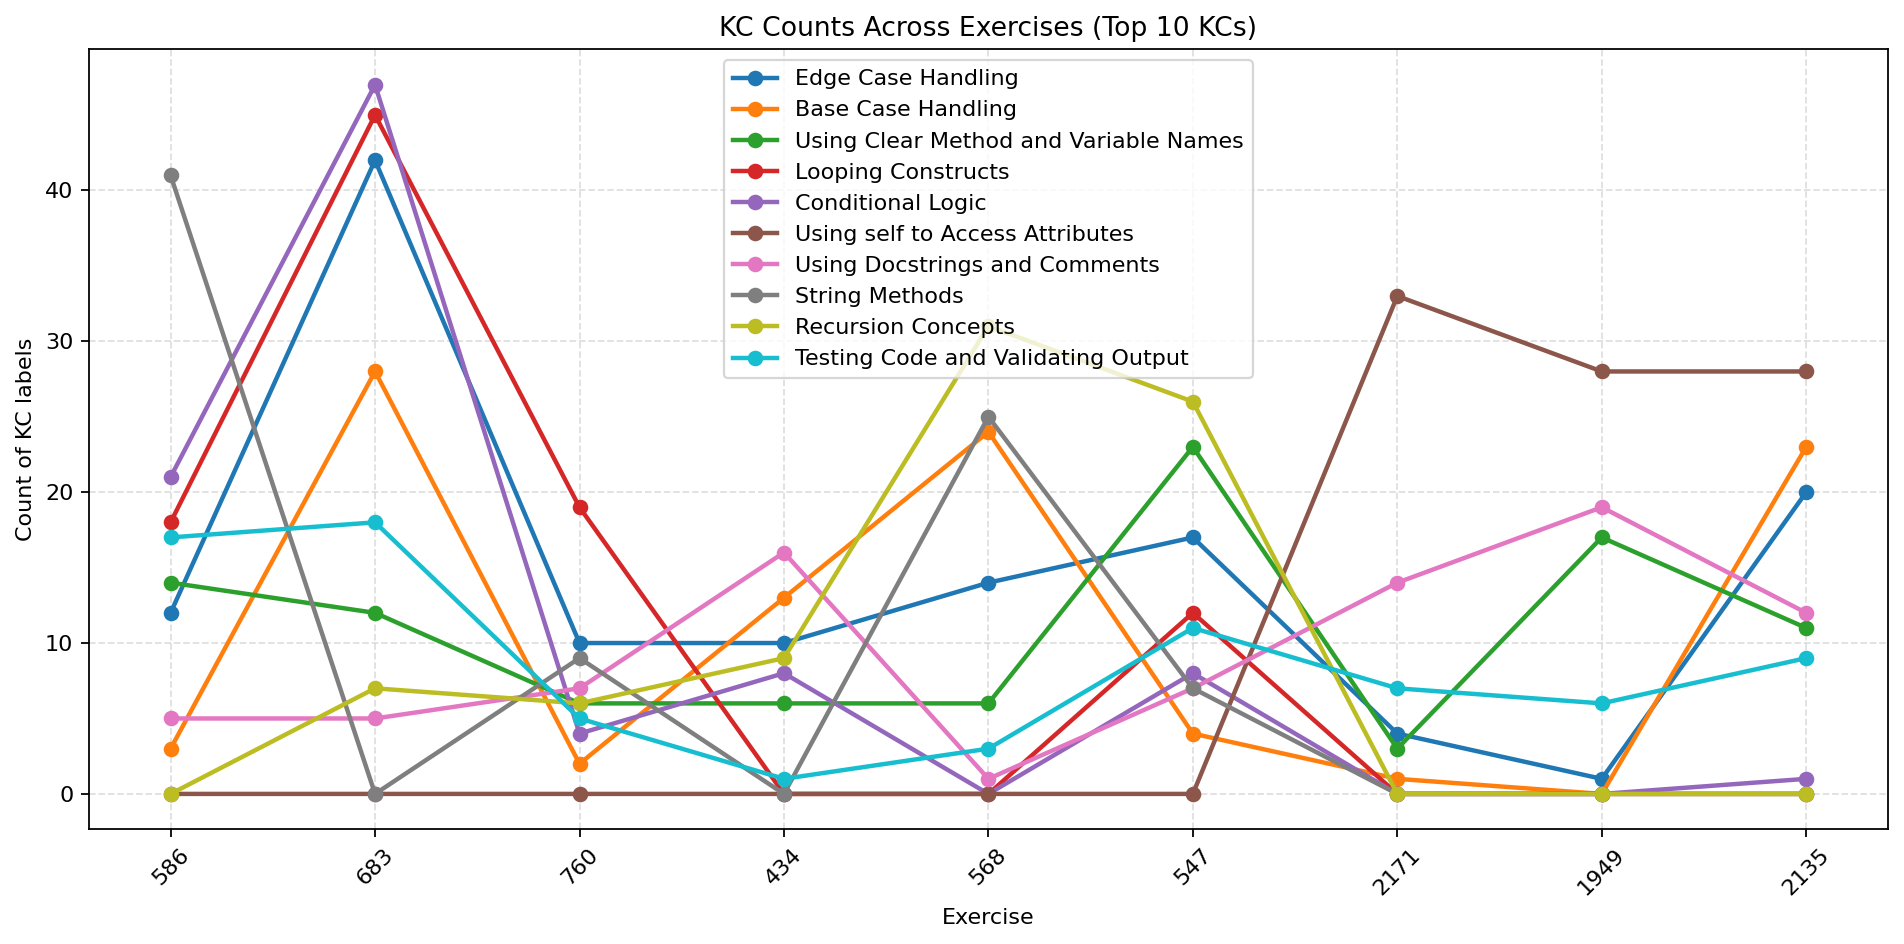

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_kc_trajectories(main_df: pd.DataFrame,
                         exercise_order=(586, 683, 760, 434, 568, 547, 2171, 1949, 2135),
                         kc_col="KC Label",
                         exercise_col="Exercise",
                         top_k=10):

    # keep only selected exercises
    df = main_df.loc[main_df[exercise_col].isin(exercise_order), [exercise_col, kc_col]].dropna(subset=[kc_col]).copy()

    # explode comma-separated KC labels
    df["kc"] = df[kc_col].astype(str).str.split(",")
    df = df.explode("kc")
    df["kc"] = df["kc"].str.strip()

    # aggregate counts per exercise × KC
    counts = (  
        df.groupby([exercise_col, "kc"])
          .size()
          .unstack(fill_value=0)
          .reindex(exercise_order)
          .rename_axis("Exercise")
    )

    # get top-K KCs overall
    top_kc = counts.sum(axis=0).nlargest(top_k).index
    counts = counts[top_kc]

    # reindex to fixed order
    order = list(exercise_order)
    counts = counts.reindex(order)

    # plot
    fig, ax = plt.subplots(figsize=(12, 6), dpi=160)
    x = range(len(order))

    for col in counts.columns:
        ax.plot(x, counts[col].values, marker="o", linewidth=2, label=col)

    ax.set_xticks(x)
    ax.set_xticklabels(order, rotation=45)
    ax.set_xlabel("Exercise")
    ax.set_ylabel("Count of KC labels")
    ax.set_title(f"KC Counts Across Exercises (Top {top_k} KCs)")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return counts  # optional: inspect exact values

# usage
kc_counts_df = plot_kc_trajectories(main_df, top_k=10)
